In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.options.display.max_columns = 15
pd.options.display.max_rows = 20
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,8)
plt.style.use('dark_background')

# Analysis of Real Estate Data and Covid in the Manhattan area

In [192]:
# We first import the data
rent_df = pd.read_csv("data/real_estate/fresh_rent_data.csv", parse_dates=True)
rent_df = rent_df.replace('None', np.nan)

rent_df['date'] = pd.to_datetime(rent_df['date'])
rent_df = rent_df.astype({
    'area': np.float64,
    'beds': np.float64,
    'baths': np.float64,
})
rent_df = rent_df.rename({"BOROUGH": "borough"}, axis=1)
rent_df = rent_df.drop(['zillow_id', 'living_area', 'lot_area', 'beds', 'baths', 'status_type', 'zip_code'], axis=1)

The structure of the data is:

In [193]:
rent_df

date event_description  price address_city    area      home_type  \
0     2021-04-16   Listed for rent   1500      Maspeth     NaN      APARTMENT   
1     2021-03-03      Price change   1300      Maspeth   350.0      APARTMENT   
2     2021-02-17   Listed for rent   1350      Maspeth   350.0      APARTMENT   
3     2021-04-10   Listed for rent   3000      Maspeth     NaN   MULTI_FAMILY   
4     2021-03-23   Listed for rent   3200     Flushing  3000.0  SINGLE_FAMILY   
...          ...               ...    ...          ...     ...            ...   
48316 2021-03-13  No price history   2500      Bayside  1100.0      APARTMENT   
48317 2021-03-12  No price history   2400      Bayside     NaN      APARTMENT   
48318 2021-02-01  No price history   2299      Bayside  1000.0   MULTI_FAMILY   
48319 2021-01-04  No price history   2274      Bayside     NaN   MULTI_FAMILY   
48320 2020-01-21  No price history   2500      Bayside     NaN   MULTI_FAMILY   

      borough  
0      queens  
1      queens  
2      queens  
3      queens  
4      queens  
...       ...  
48316  queens  
48317  queens  
48318  queens  
48319  queens  
48320  queens  

[48321 rows x 7 columns]

We divide the data into boroughs to analyze them individually

In [194]:
rent_ny = {
    'queens': rent_df[rent_df['borough'] == 'queens'],
    'bronx': rent_df[rent_df['borough'] == 'bronx'],
    'brooklyn': rent_df[rent_df['borough'] == 'brooklyn'],
    'staten': rent_df[rent_df['borough'] == 'staten_island'],
    'manhattan': rent_df[rent_df['borough'] == 'manhattan'],
}

Our analysis for real estate data starts from 01/01/2020 so we need to remove the properties with a date
before 01/01/2020


# Time Series Analysis on Queens

In [195]:
current_borough = 'queens'
rent_df = rent_ny[current_borough]
print(rent_df['price'].describe())

count     7970.000000
mean      2219.329235
std        777.962233
min        640.000000
25%       1750.000000
50%       2044.500000
75%       2500.000000
max      22100.000000
Name: price, dtype: float64


Remove outliers from the data

In [196]:
rent_df.drop(rent_df[rent_df['price'] > 7_000].index, inplace=True)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [197]:
# Create a time series for average price, median price, and count  from the manhattan dataframe
rent_ts = rent_df.groupby(rent_df.date)['price'].agg(['mean','count', 'median'])
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2021, 4, 1)
idx = pd.date_range(start, end)
rent_ts = rent_ts[(rent_ts.index >= start) & (rent_ts.index <= end)]
rent_ts = rent_ts.reindex(idx)
rent_ts = rent_ts.rename({
    'mean': 'mean_price',
    'count': 'rent_count',
    'median': 'median_price'
}, axis=1)
rent_ts

mean_price  rent_count  median_price
2020-01-01          NaN         NaN           NaN
2020-01-02          NaN         NaN           NaN
2020-01-03  1800.000000         1.0        1800.0
2020-01-04          NaN         NaN           NaN
2020-01-05          NaN         NaN           NaN
...                 ...         ...           ...
2021-03-28  2208.329787        94.0        2125.0
2021-03-29  2196.854369       103.0        1999.0
2021-03-30  2236.183333       120.0        2100.0
2021-03-31  2223.877551        98.0        2000.0
2021-04-01  2237.546667        75.0        2000.0

[457 rows x 3 columns]

Raw time series for Manhattan

<AxesSubplot:>

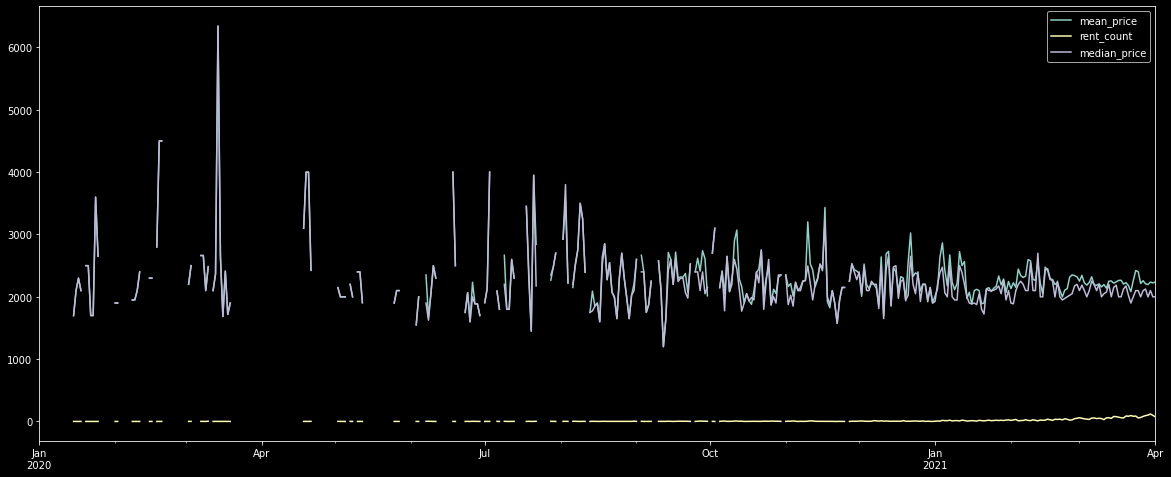

In [198]:
rent_ts.plot()


We need to fill in missing values. We use interpolation to do so

In [199]:
rent_ts = rent_ts.interpolate(method='spline', order=2)

<AxesSubplot:>

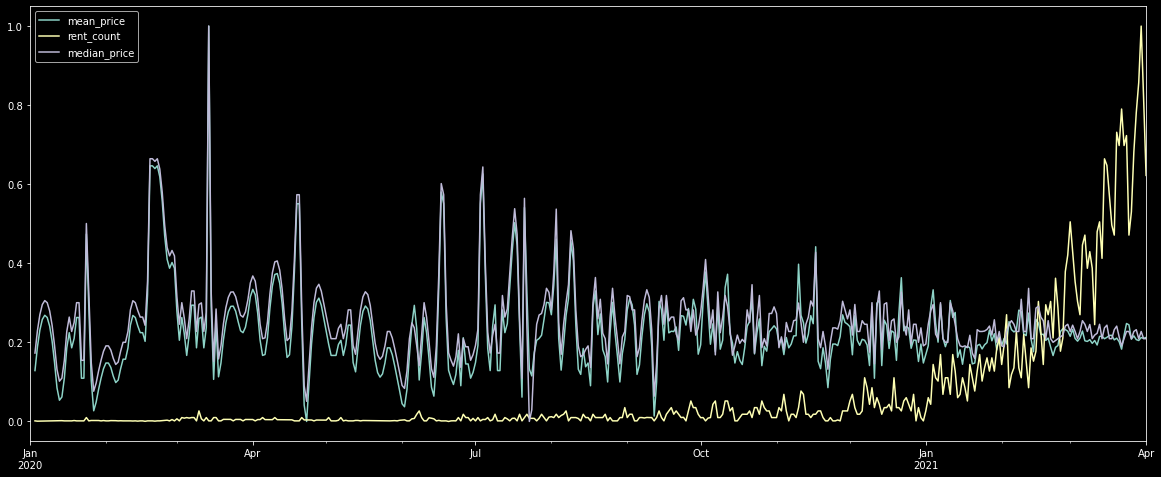

In [200]:
scaler = MinMaxScaler()
rent_ts = pd.DataFrame(scaler.fit_transform(rent_ts), index=rent_ts.index, columns=rent_ts.columns)
rent_ts.plot()

Now we need to smooth the data using a rolling window of 5 days and scale the data using min-max scaling.

We might need to use a trailing window because we are trying to forecast into the future.

Comparison between different smoothing options:

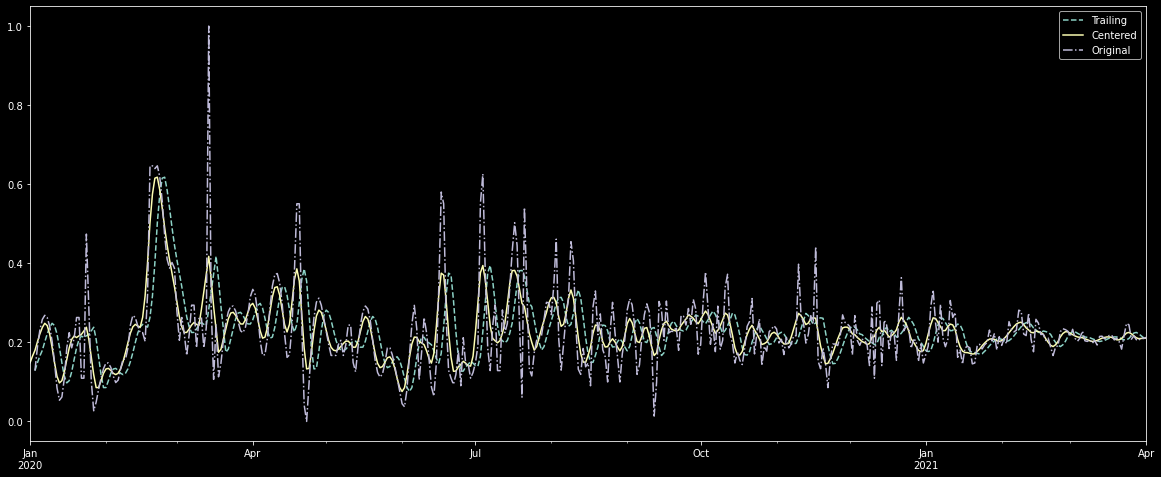

In [201]:
fig, ax = plt.subplots()
smoothed_ts = rent_ts['mean_price'].rolling(7, win_type='triang', min_periods=1).mean()
smoothed_ts.plot(style='--', legend=True, ax=ax)
smoothed_ts_centered = rent_ts['mean_price'].rolling(7, win_type='triang', min_periods=1, center=True).mean()
smoothed_ts_centered.plot(legend=True, ax=ax)
smoothed_ts_not_smoothed = rent_ts['mean_price']
smoothed_ts_not_smoothed.plot(style='-.', legend=True, ax=ax)
ax.legend(["Trailing", "Centered", "Original"])


We also explore the price/sqr_feet

In [202]:
# we take the properties that actually have the area listed
price_sqft = rent_df[ ~rent_df['area'].isna() ].sort_values('date')
price_sqft['price_per_sqft'] = price_sqft['price']/price_sqft['area']

price_sqft = price_sqft.groupby(price_sqft.date)['price_per_sqft'].agg(['mean', 'median'])
price_sqft = price_sqft.rename({
    'mean': 'mean_price_per_sqft',
    'median': 'median_price_per_sqft'
}, axis=1)
price_sqft = price_sqft.reindex(idx)
price_sqft = price_sqft.interpolate(method='spline', order=2)
price_sqft = pd.DataFrame(scaler.fit_transform(price_sqft), index=price_sqft.index, columns=price_sqft.columns)
# price_sqft = price_sqft.rolling(7, win_type='triang', min_periods=1).mean()
rent_ts = pd.concat([rent_ts, price_sqft], axis=1)
rent_ts

mean_price  rent_count  median_price  mean_price_per_sqft  \
2020-01-01         NaN         NaN           NaN                  NaN   
2020-01-02         NaN         NaN           NaN                  NaN   
2020-01-03    0.128612    0.001402      0.172930                  NaN   
2020-01-04    0.187947    0.000663      0.229248                  NaN   
2020-01-05    0.231041    0.000822      0.270150                  NaN   
...                ...         ...           ...                  ...   
2021-03-28    0.206933    0.781819      0.232098             0.470068   
2021-03-29    0.204732    0.857343      0.209159             0.477267   
2021-03-30    0.212276    1.000000      0.227546             0.476191   
2021-03-31    0.209916    0.815385      0.209341             0.467613   
2021-04-01    0.212537    0.622379      0.209341             0.448158   

            median_price_per_sqft  
2020-01-01                    NaN  
2020-01-02                    NaN  
2020-01-03                    NaN  
2020-01-04                    NaN  
2020-01-05                    NaN  
...                           ...  
2021-03-28               0.432994  
2021-03-29               0.441757  
2021-03-30               0.453097  
2021-03-31               0.455451  
2021-04-01               0.454696  

[457 rows x 5 columns]

# Introducing COVID data

In [203]:
nyc_covid_df = pd.read_csv("data/covid/covid_county.csv")
nyc_covid_df = nyc_covid_df[nyc_covid_df['countyname'] == 'Queens']
nyc_covid_df.set_index("date", drop=True)
nyc_covid_df.drop(['county_pop2019', 'countyfips', 'cityname', 'countyname'], axis=1, inplace=True)
nyc_covid_df['date'] = pd.to_datetime(nyc_covid_df['date'])
nyc_covid_df = nyc_covid_df[(nyc_covid_df['date'] >= start) & (nyc_covid_df['date'] <= end)]
nyc_covid_ts = nyc_covid_df.set_index('date', drop=True)
nyc_covid_ts = nyc_covid_ts.rename({col: col + "_covid" for col in nyc_covid_ts.columns}, axis=1)

Covid raw data:

In [204]:
nyc_covid_ts

new_case_count_covid  new_death_count_covid  new_test_count_covid  \
date                                                                            
2020-01-22                     0                      0                     0   
2020-01-23                     0                      0                     0   
2020-01-24                     0                      0                     0   
2020-01-25                     0                      0                     0   
2020-01-26                     0                      0                     0   
...                          ...                    ...                   ...   
2021-03-28                  1715                     19                 22966   
2021-03-29                  1928                     23                 22798   
2021-03-30                  2034                     23                 22373   
2021-03-31                  1223                     17                 21831   
2021-04-01                  1240                     16                 21099   

            new_case_rate_covid  new_death_rate_covid  new_test_rate_covid  \
date                                                                         
2020-01-22                  0.0                 0.000                  0.0   
2020-01-23                  0.0                 0.000                  0.0   
2020-01-24                  0.0                 0.000                  0.0   
2020-01-25                  0.0                 0.000                  0.0   
2020-01-26                  0.0                 0.000                  0.0   
...                         ...                   ...                  ...   
2021-03-28                 76.1                 0.843               1019.0   
2021-03-29                 85.5                 1.030               1012.0   
2021-03-30                 90.2                 1.030                993.0   
2021-03-31                 54.3                 0.754                969.0   
2021-04-01                 55.0                 0.704                936.0   

            case_count_covid  case_rate_covid  death_count_covid  \
date                                                               
2020-01-22                 0              0.0                  0   
2020-01-23                 0              0.0                  0   
2020-01-24                 0              0.0                  0   
2020-01-25                 0              0.0                  0   
2020-01-26                 0              0.0                  0   
...                      ...              ...                ...   
2021-03-28            236388          10488.0               8630   
2021-03-29            238316          10574.0               8653   
2021-03-30            240350          10664.0               8676   
2021-03-31            241573          10718.0               8693   
2021-04-01            242814          10773.0               8709   

            death_rate_covid  test_count_covid  test_rate_covid  
date                                                             
2020-01-22               0.0                 0              0.0  
2020-01-23               0.0                 0              0.0  
2020-01-24               0.0                 0              0.0  
2020-01-25               0.0                 0              0.0  
2020-01-26               0.0                 0              0.0  
...                      ...               ...              ...  
2021-03-28             383.0           4597705         203993.0  
2021-03-29             384.0           4620504         205004.0  
2021-03-30             385.0           4642877         205997.0  
2021-03-31             386.0           4664708         206965.0  
2021-04-01             386.0           4685807         207902.0  

[436 rows x 12 columns]

<AxesSubplot:xlabel='date'>

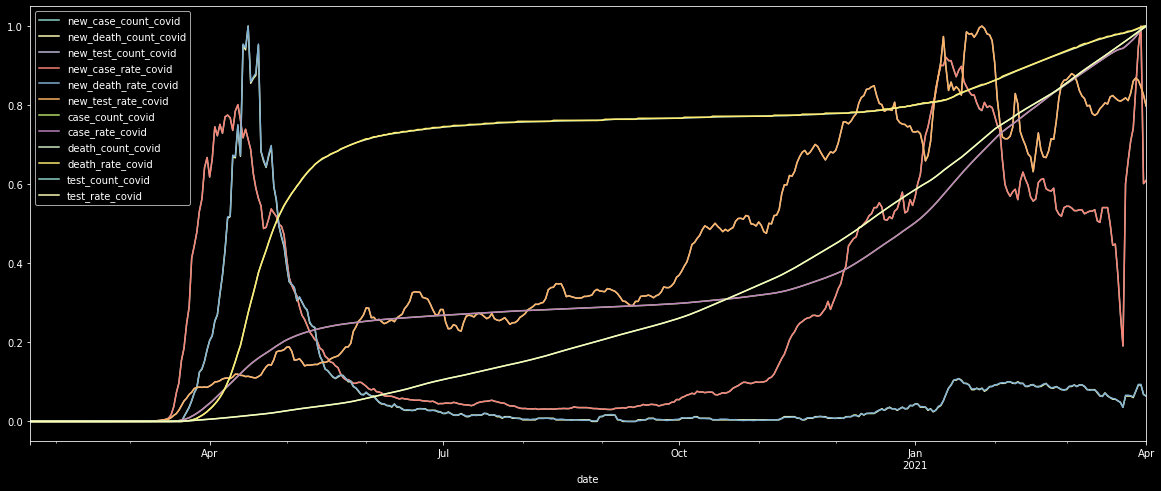

In [205]:
nyc_covid_ts = pd.DataFrame(scaler.fit_transform(nyc_covid_ts), columns=nyc_covid_ts.columns, index=nyc_covid_ts.index)
nyc_covid_ts.plot()


In [206]:
ts = pd.concat([rent_ts, nyc_covid_ts], axis=1)

In [207]:
ts

mean_price  rent_count  median_price  mean_price_per_sqft  \
2020-01-01         NaN         NaN           NaN                  NaN   
2020-01-02         NaN         NaN           NaN                  NaN   
2020-01-03    0.128612    0.001402      0.172930                  NaN   
2020-01-04    0.187947    0.000663      0.229248                  NaN   
2020-01-05    0.231041    0.000822      0.270150                  NaN   
...                ...         ...           ...                  ...   
2021-03-28    0.206933    0.781819      0.232098             0.470068   
2021-03-29    0.204732    0.857343      0.209159             0.477267   
2021-03-30    0.212276    1.000000      0.227546             0.476191   
2021-03-31    0.209916    0.815385      0.209341             0.467613   
2021-04-01    0.212537    0.622379      0.209341             0.448158   

            median_price_per_sqft  new_case_count_covid  \
2020-01-01                    NaN                   NaN   
2020-01-02                    NaN                   NaN   
2020-01-03                    NaN                   NaN   
2020-01-04                    NaN                   NaN   
2020-01-05                    NaN                   NaN   
...                           ...                   ...   
2021-03-28               0.432994              0.843166   
2021-03-29               0.441757              0.947886   
2021-03-30               0.453097              1.000000   
2021-03-31               0.455451              0.601278   
2021-04-01               0.454696              0.609636   

            new_death_count_covid  ...  new_test_rate_covid  case_count_covid  \
2020-01-01                    NaN  ...                  NaN               NaN   
2020-01-02                    NaN  ...                  NaN               NaN   
2020-01-03                    NaN  ...                  NaN               NaN   
2020-01-04                    NaN  ...                  NaN               NaN   
2020-01-05                    NaN  ...                  NaN               NaN   
...                           ...  ...                  ...               ...   
2021-03-28               0.076305  ...             0.868713          0.973535   
2021-03-29               0.092369  ...             0.862745          0.981476   
2021-03-30               0.092369  ...             0.846547          0.989852   
2021-03-31               0.068273  ...             0.826087          0.994889   
2021-04-01               0.064257  ...             0.797954          1.000000   

            case_rate_covid  death_count_covid  death_rate_covid  \
2020-01-01              NaN                NaN               NaN   
2020-01-02              NaN                NaN               NaN   
2020-01-03              NaN                NaN               NaN   
2020-01-04              NaN                NaN               NaN   
2020-01-05              NaN                NaN               NaN   
...                     ...                ...               ...   
2021-03-28         0.973545           0.990929          0.992228   
2021-03-29         0.981528           0.993570          0.994819   
2021-03-30         0.989882           0.996211          0.997409   
2021-03-31         0.994895           0.998163          1.000000   
2021-04-01         1.000000           1.000000          1.000000   

            test_count_covid  test_rate_covid  
2020-01-01               NaN              NaN  
2020-01-02               NaN              NaN  
2020-01-03               NaN              NaN  
2020-01-04               NaN              NaN  
2020-01-05               NaN              NaN  
...                      ...              ...  
2021-03-28          0.981198         0.981198  
2021-03-29          0.986064         0.986061  
2021-03-30          0.990838         0.990837  
2021-03-31          0.995497         0.995493  
2021-04-01          1.000000         1.000000  

[457 rows x 17 columns]

<AxesSubplot:>

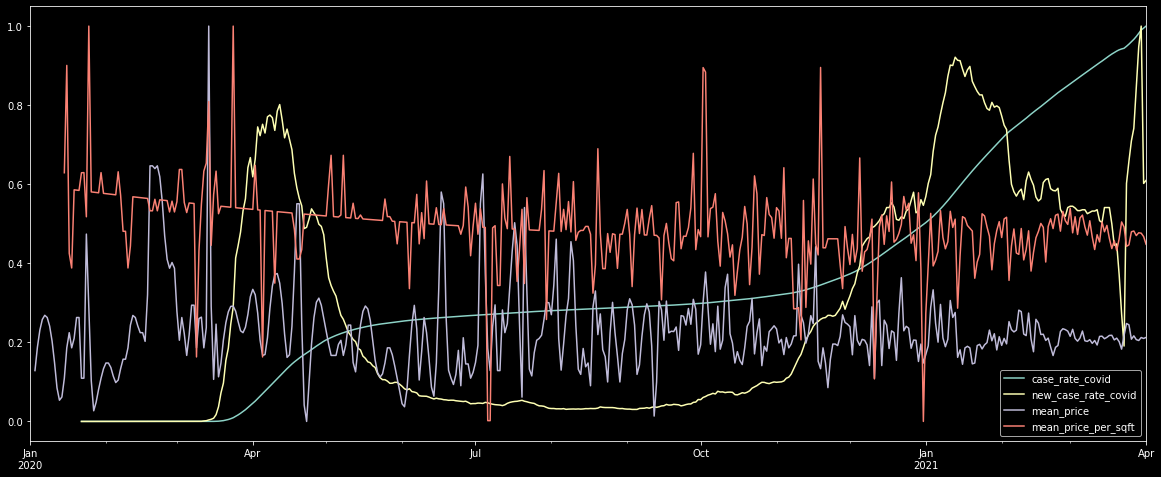

In [208]:
ts[['case_rate_covid', 'new_case_rate_covid', 'mean_price', 'mean_price_per_sqft']].plot()

# Seasonal Decompositions
Decomposition is the process of understanding generalizations and problems related to time-series forecasting.
We can leverage seasonal decomposition to remove seasonality from data and check the data only with the trend,
cyclic, and irregular variations.

First we explore the decompositions of COVID time series

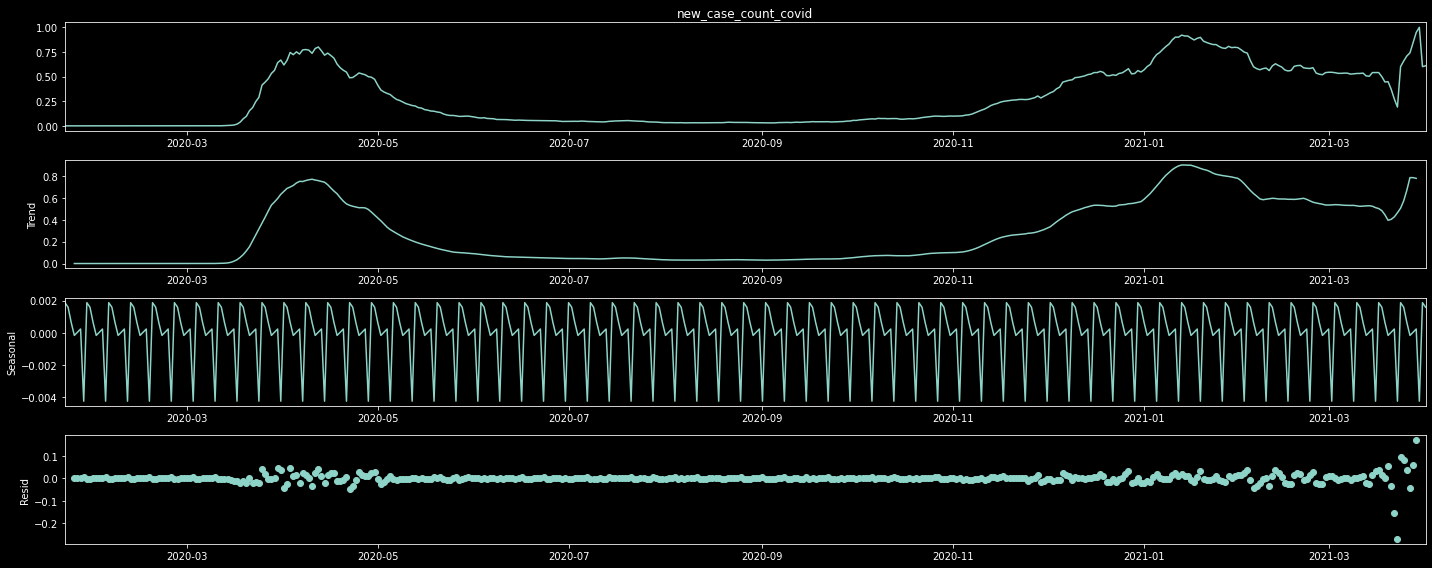

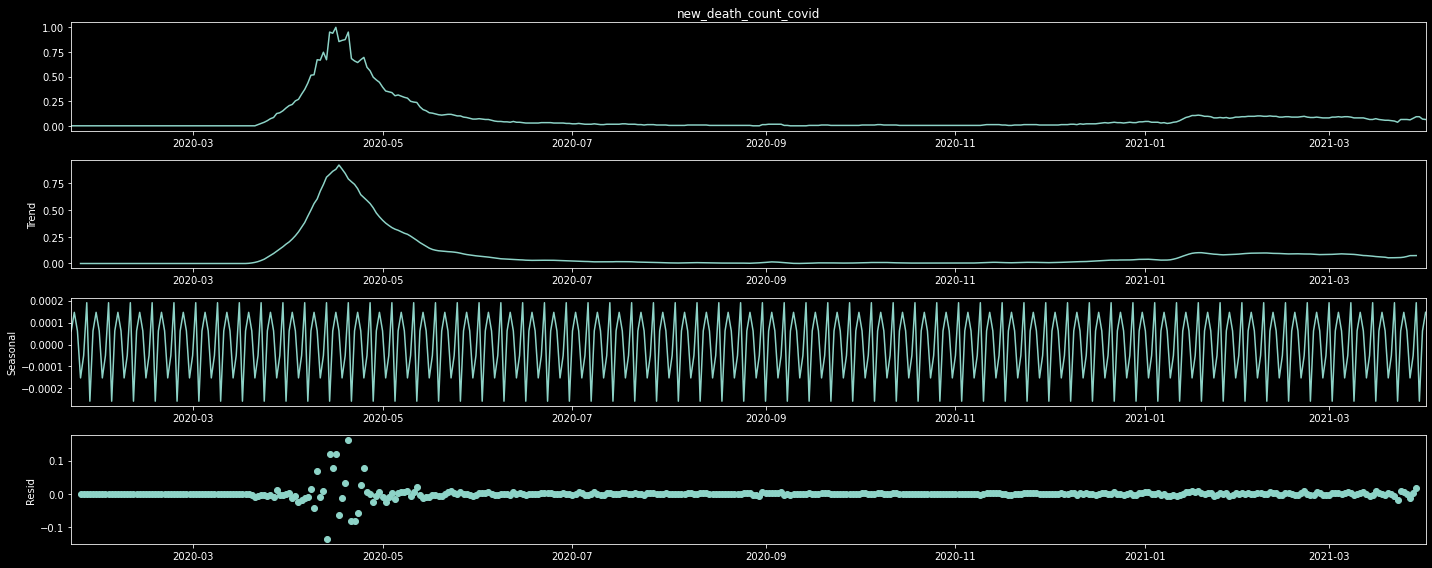

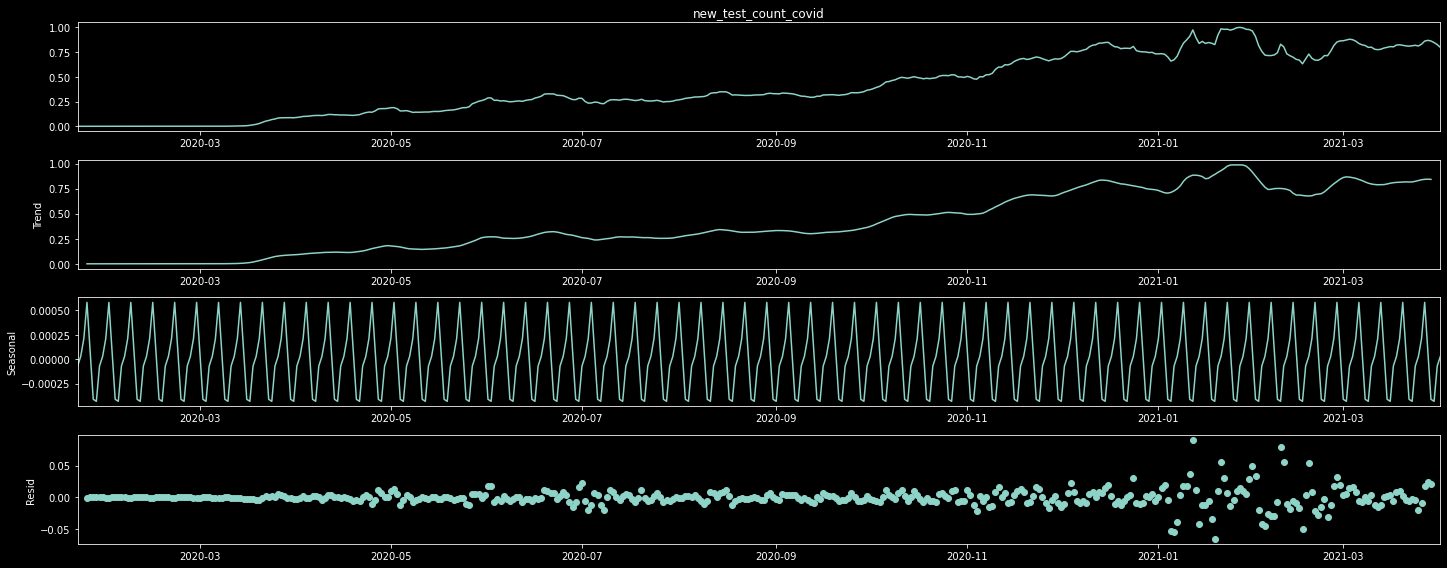

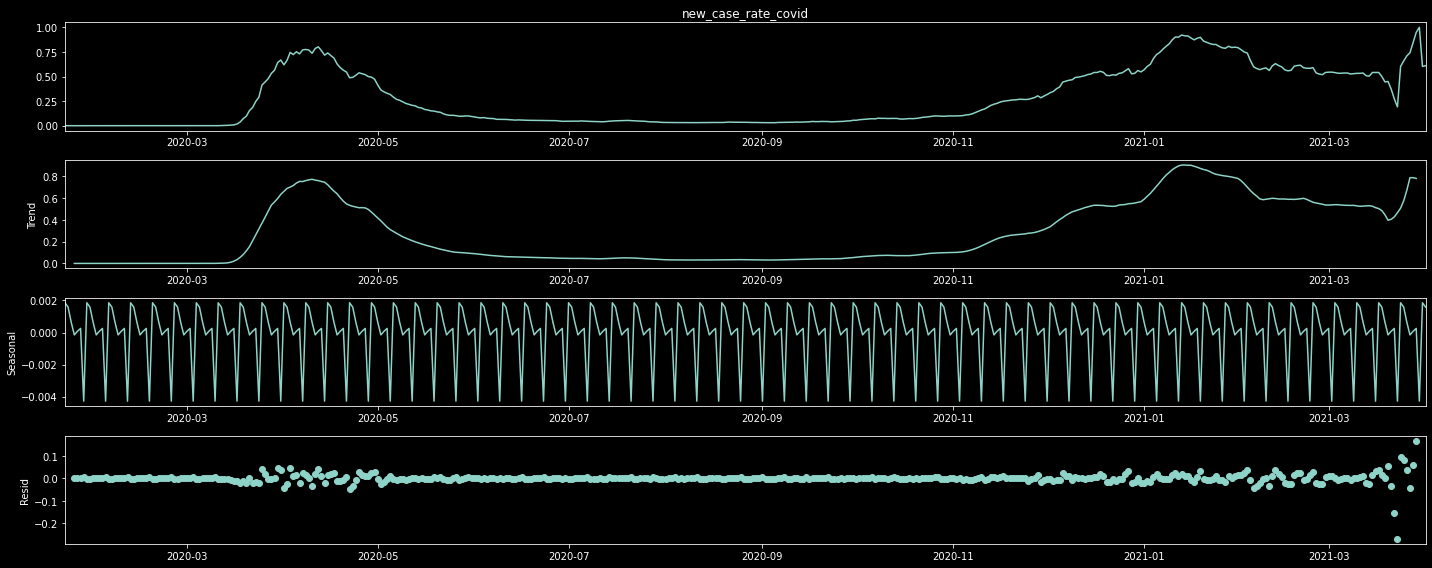

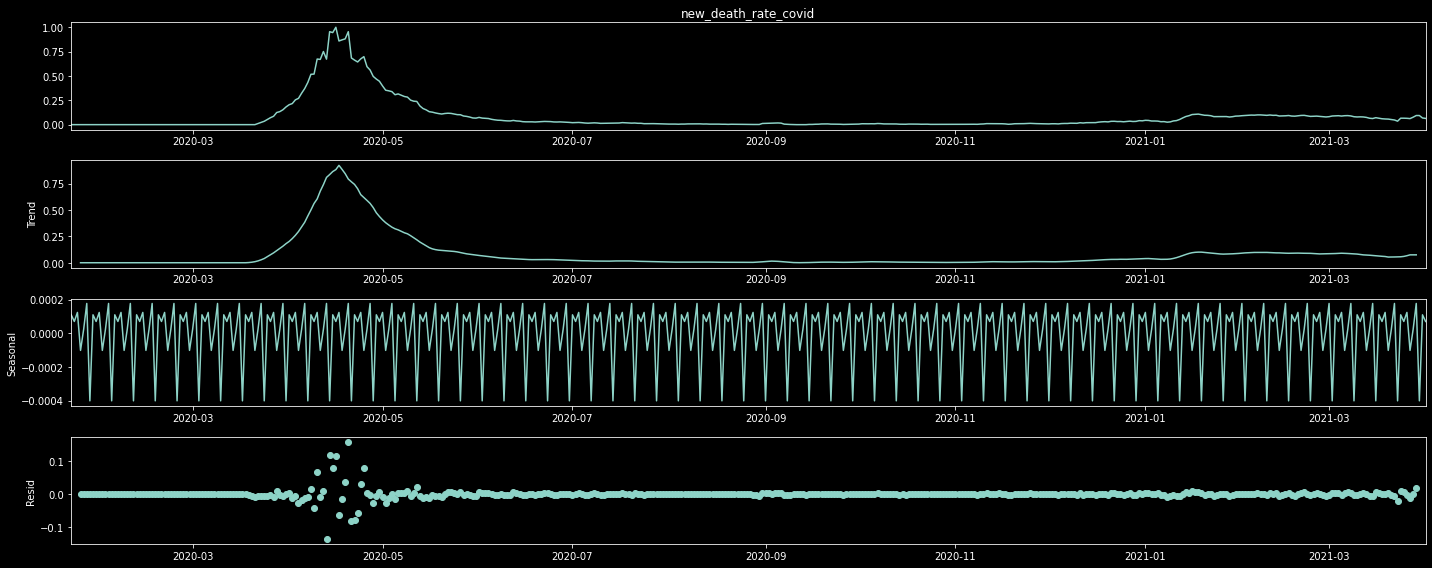

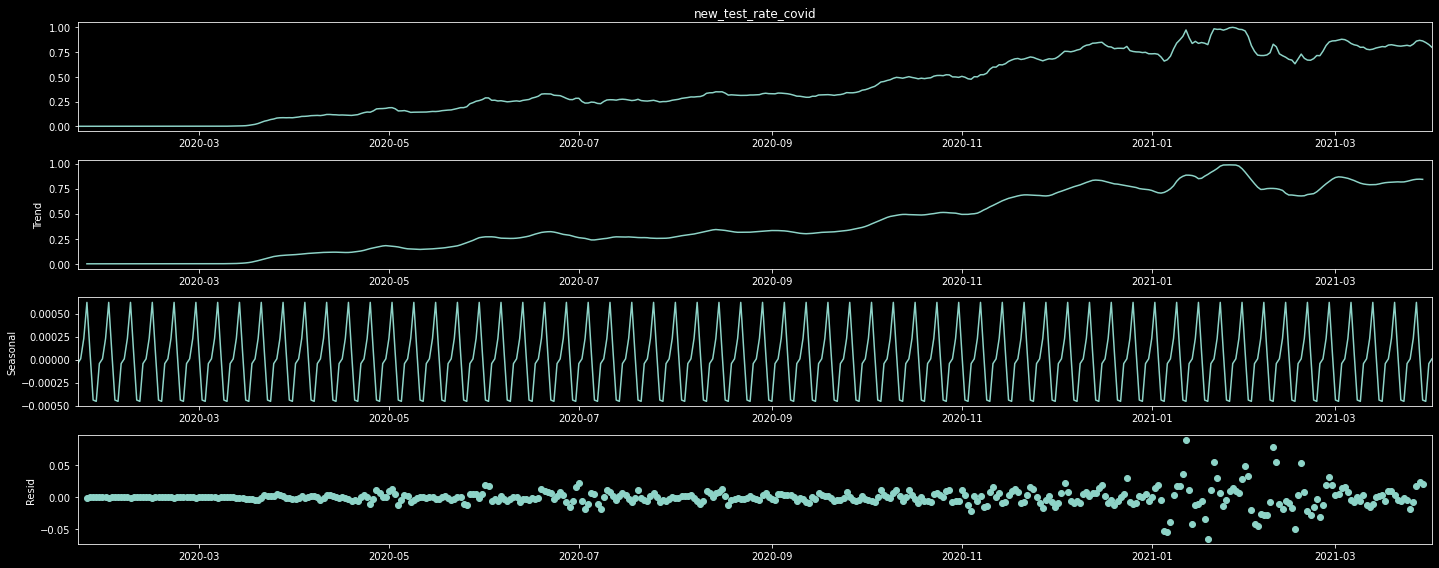

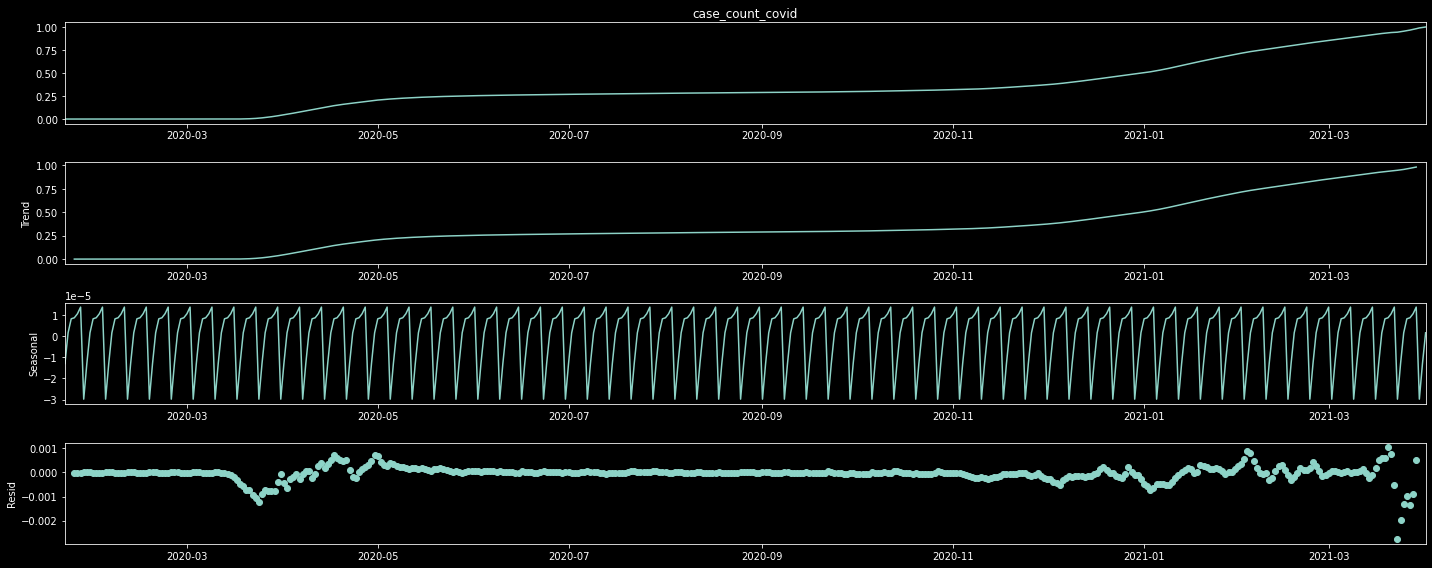

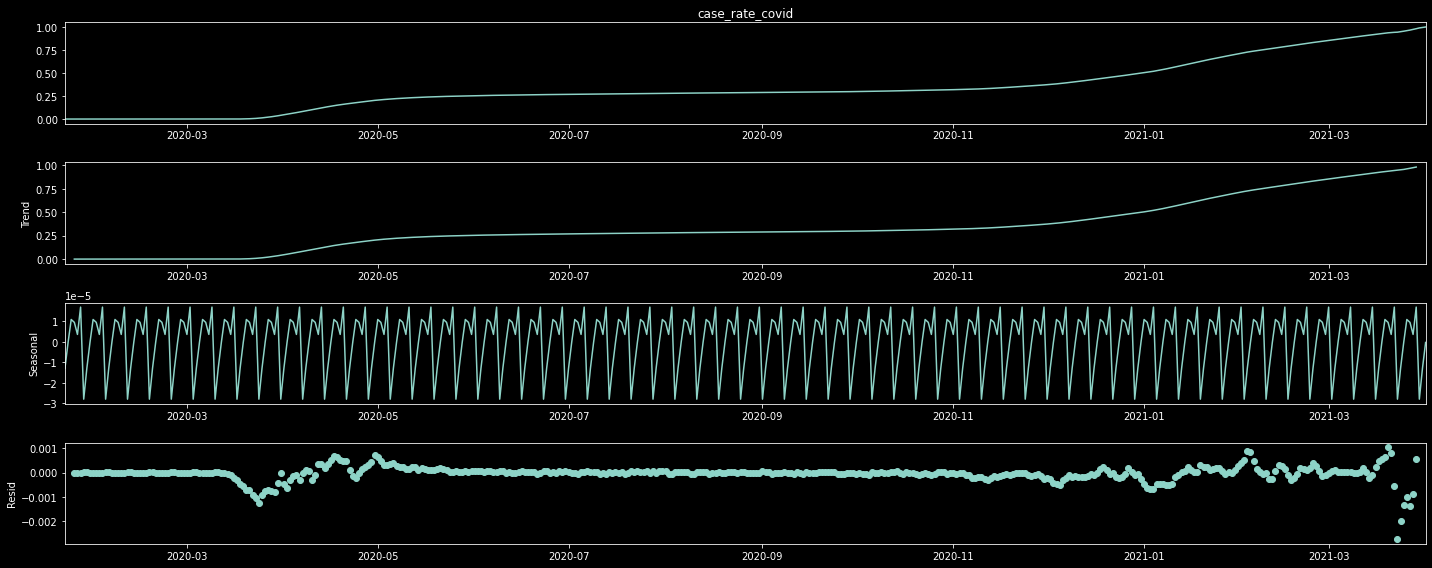

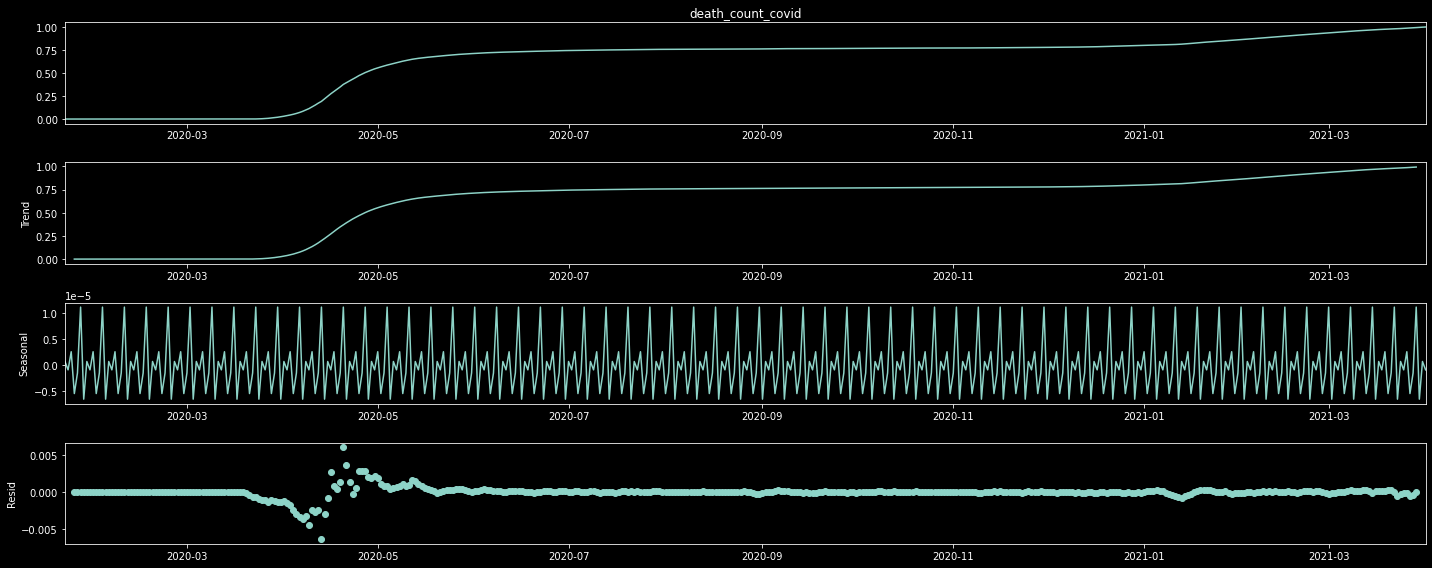

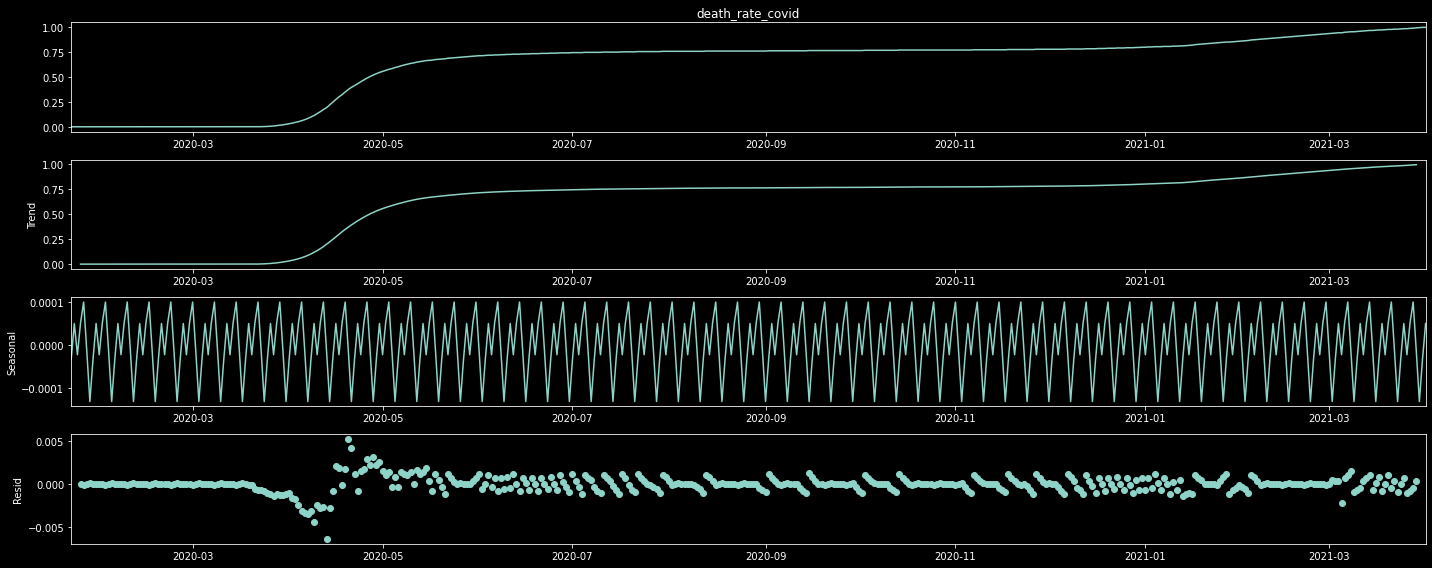

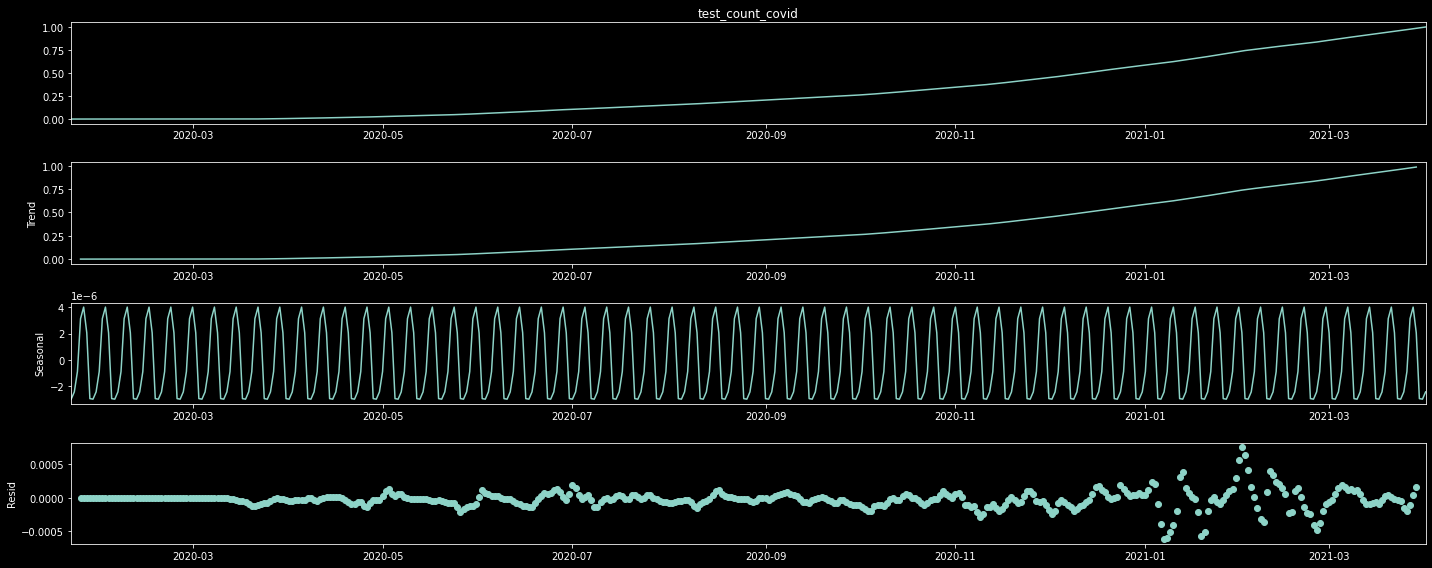

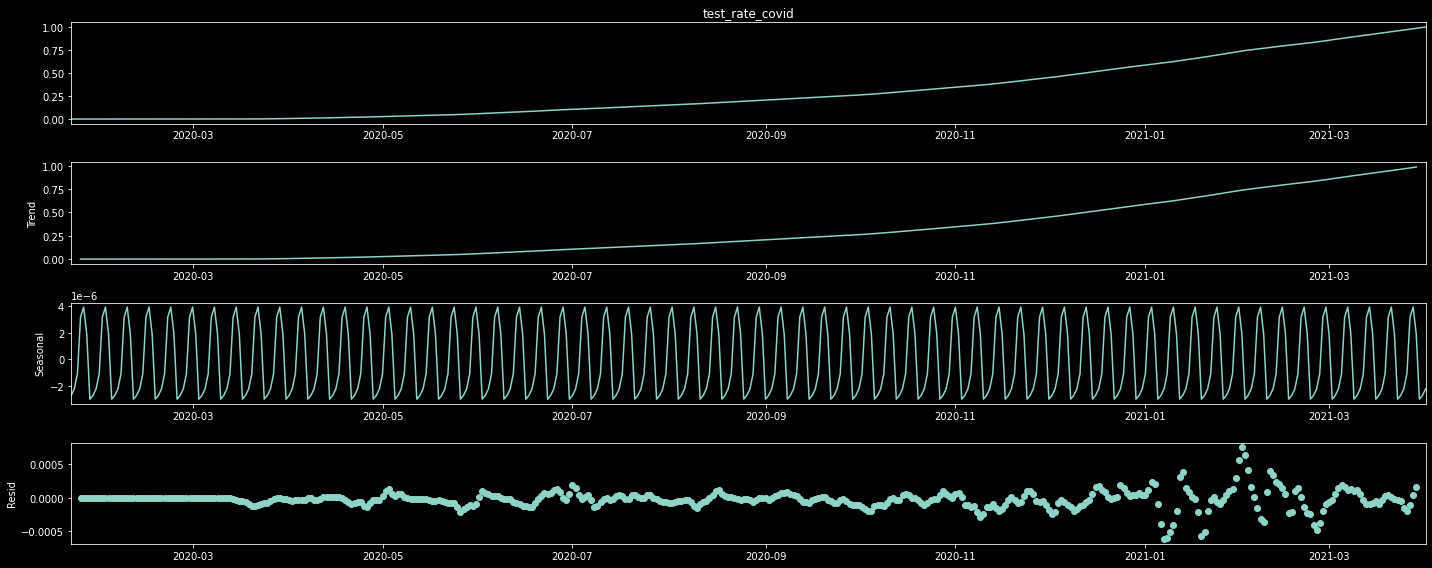

In [209]:
from statsmodels.tsa.seasonal import seasonal_decompose

residuals = dict()


legend = []
for col in ts.columns:
    if 'covid' in col:
        legend.append(col)
        covid_df = ts[col]
        covid_decomposition = seasonal_decompose(covid_df.drop(covid_df[covid_df.isna()].index), model='additive')
        residuals[col+'_resid'] = covid_decomposition.resid
        covid_decomposition.plot()

residuals_ts = pd.concat(residuals, axis=1)

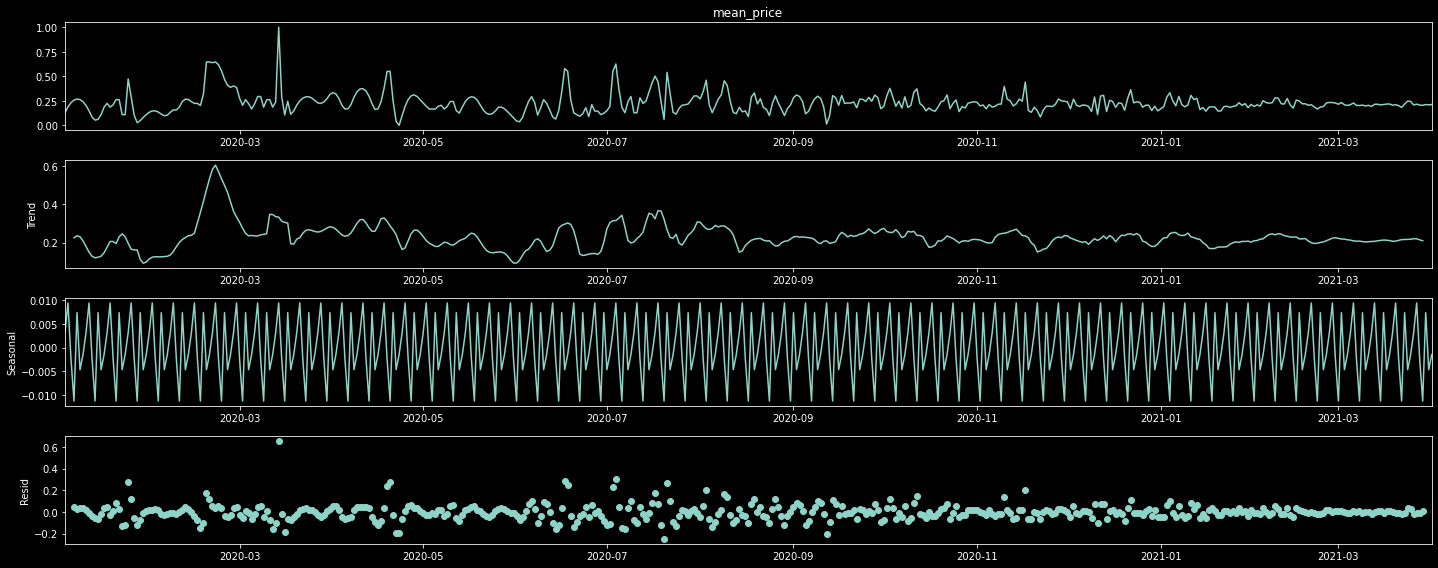

In [210]:
price = ts['mean_price']
price_decomposition = seasonal_decompose(price.drop(price[price.isna()].index), model='additive')
price_decomposition.plot()
plt.show()

In [211]:
ts = pd.concat([ts, residuals_ts, price_decomposition.resid.rename({'resid': 'mean_price_resid' }, axis=1)], axis=1)

<AxesSubplot:>

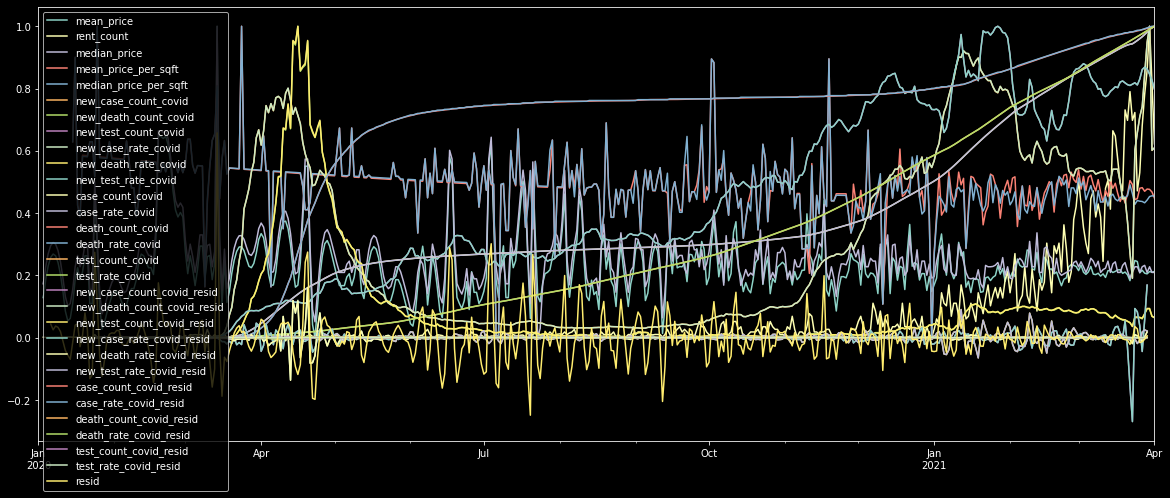

In [212]:
ts.plot()

# Autocorrelation plots
Autocorrelation is used to check randomness in data. It helps to identify types of data where the period is not known.

https://stats.stackexchange.com/questions/357300/what-does-pandas-autocorrelation-graph-show]

# covid case rate autocorrelation plot:

Ploting the PACF and ACF of case rate

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


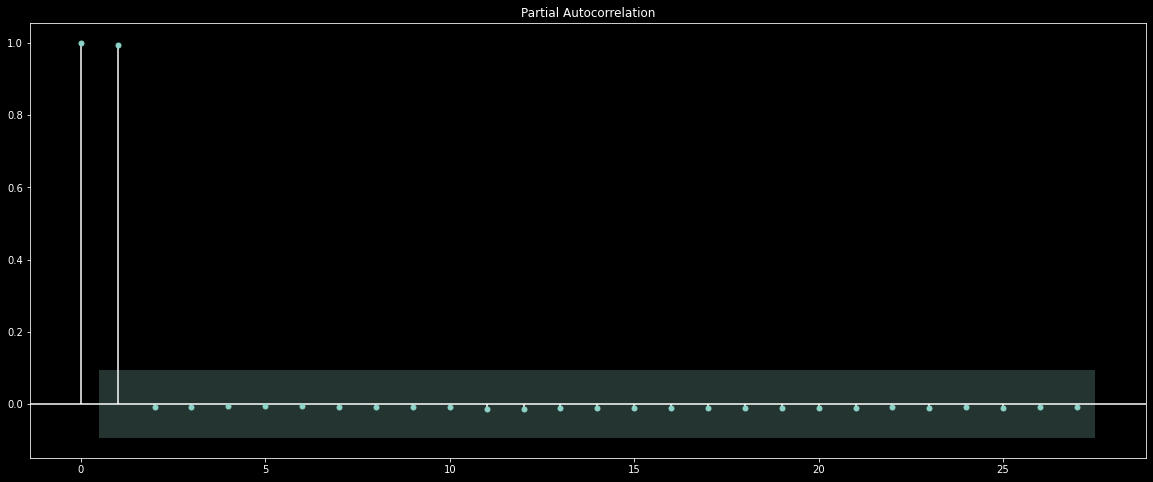

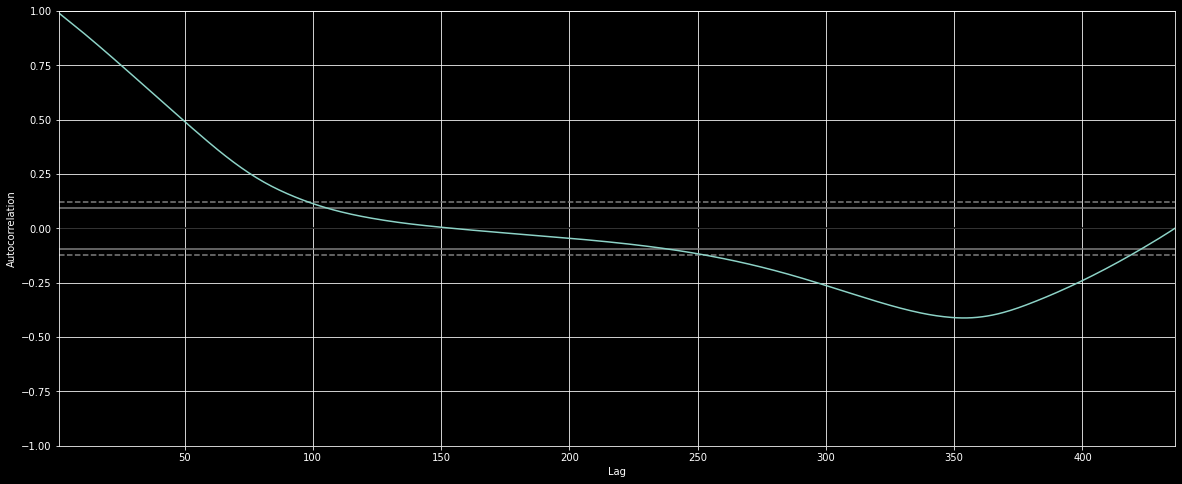

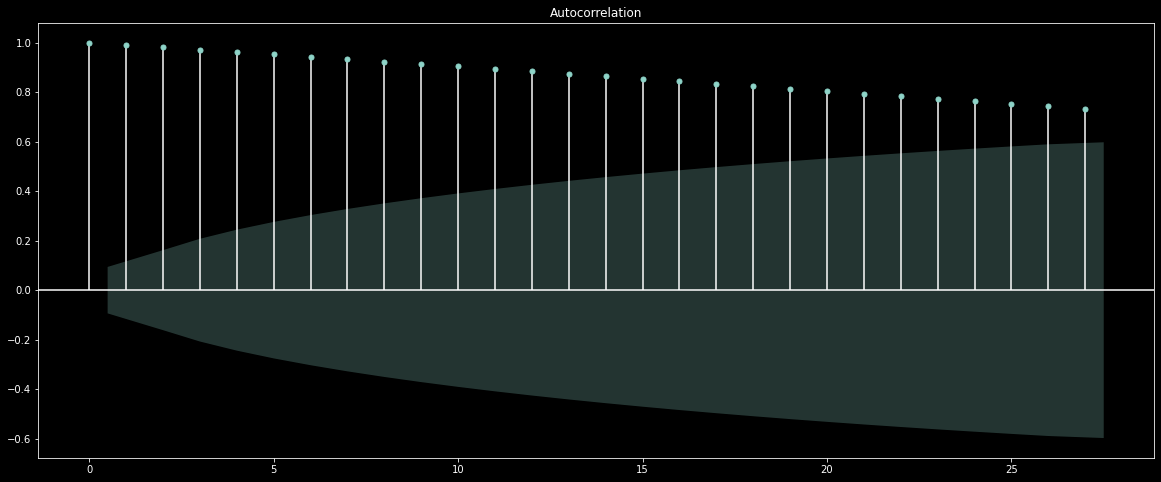

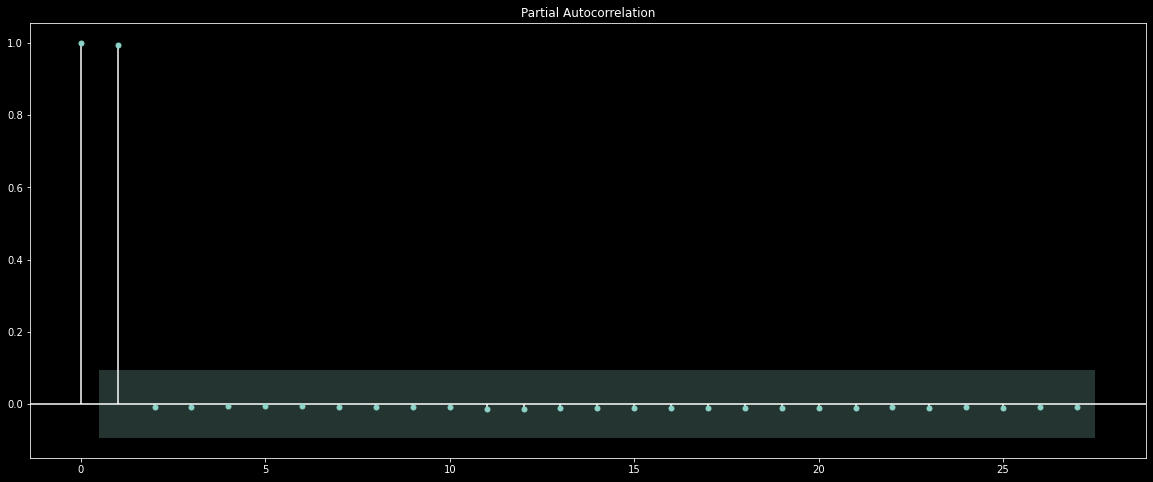

In [213]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

case_rate = ts[~ts['case_rate_covid'].isna()]['case_rate_covid']
autocorrelation_plot(case_rate.tolist())
plot_acf(case_rate)
plot_pacf(case_rate)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


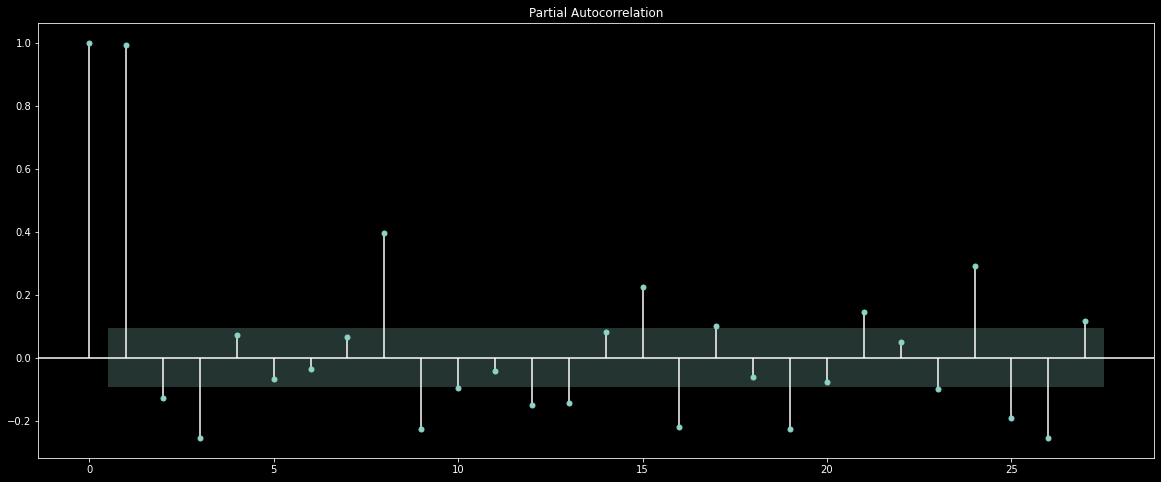

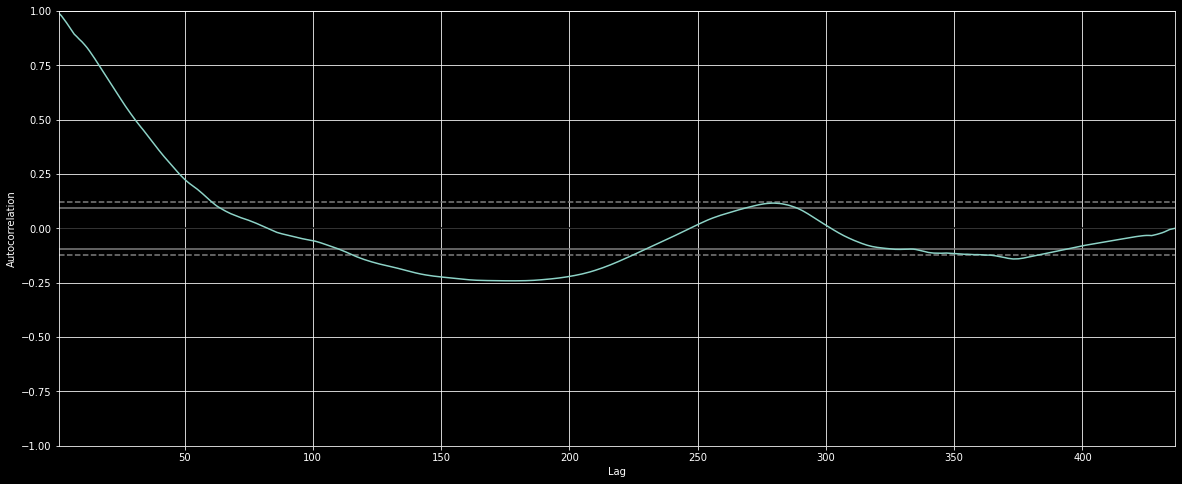

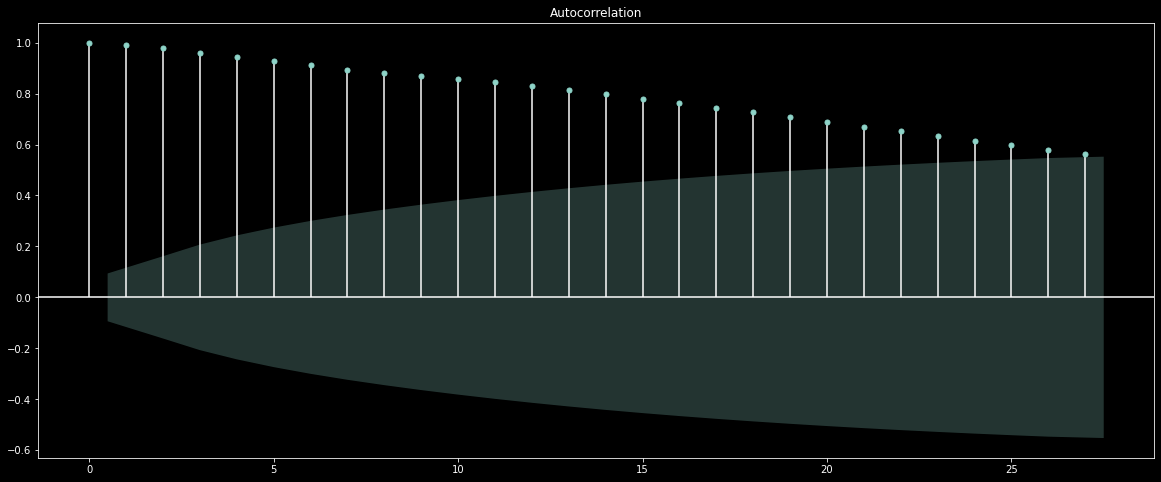

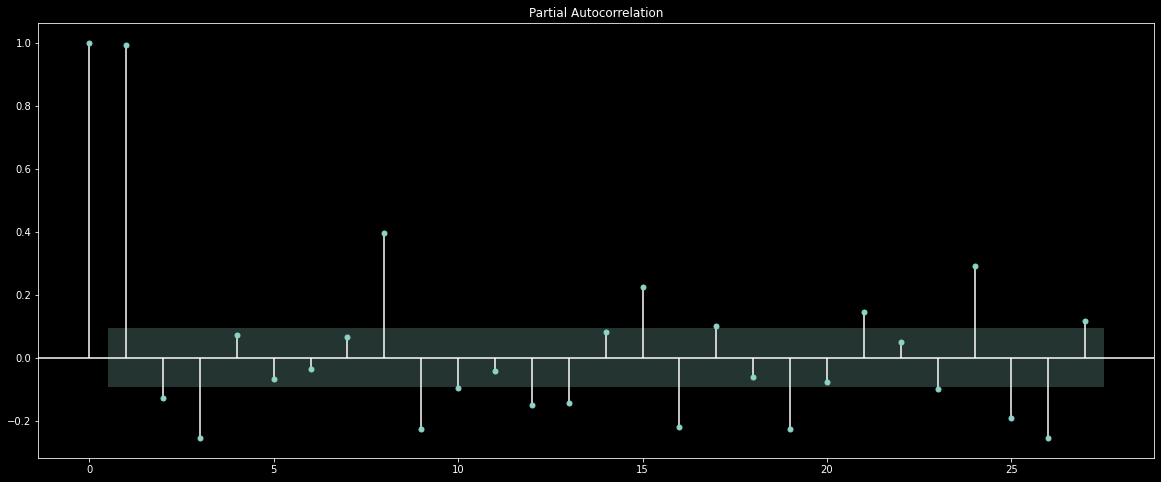

In [214]:
new_case_rate = ts[~ts['new_case_rate_covid'].isna()]['new_case_rate_covid']
autocorrelation_plot(new_case_rate.tolist())
plot_acf(new_case_rate)
plot_pacf(new_case_rate)

Ploting the PACF and ACF of mean price and number of properties for rent

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


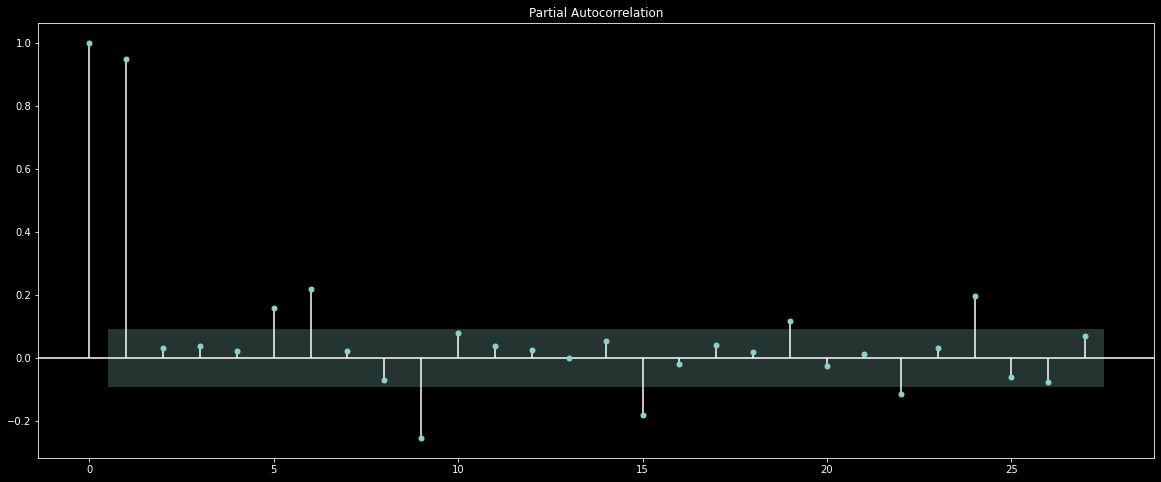

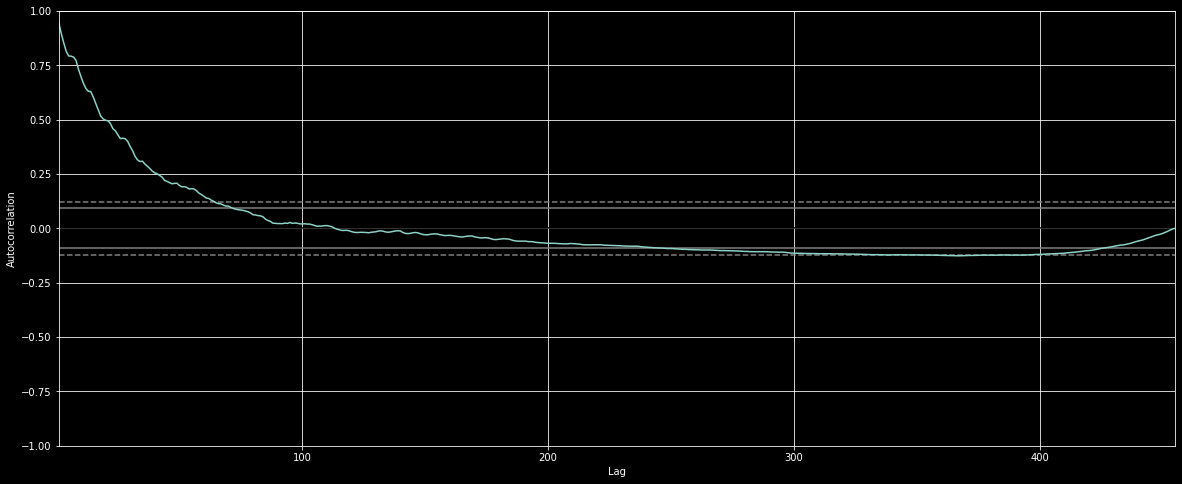

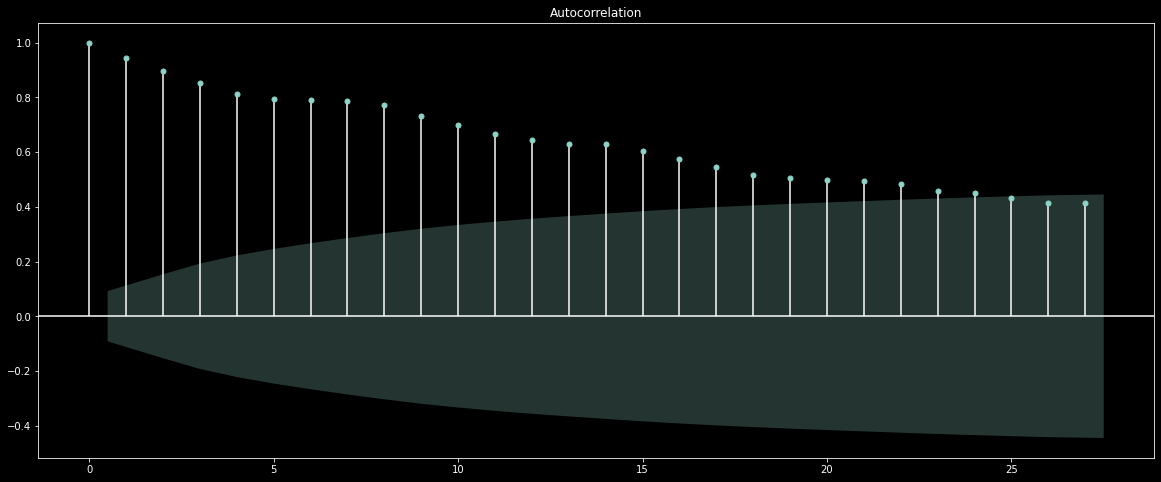

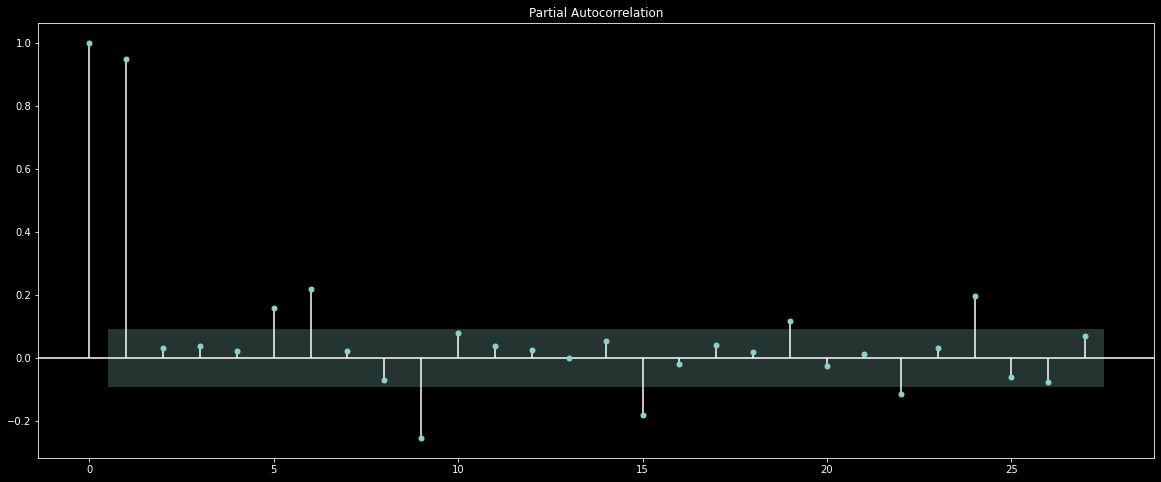

In [215]:
count = ts[~ts['rent_count'].isna()]['rent_count']
autocorrelation_plot(count)
plot_acf(count)
plot_pacf(count)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


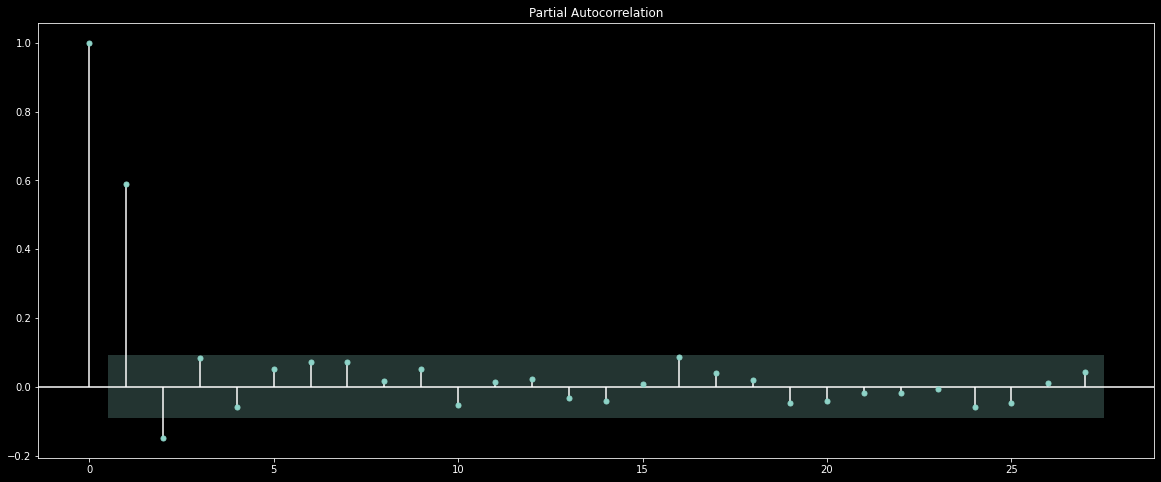

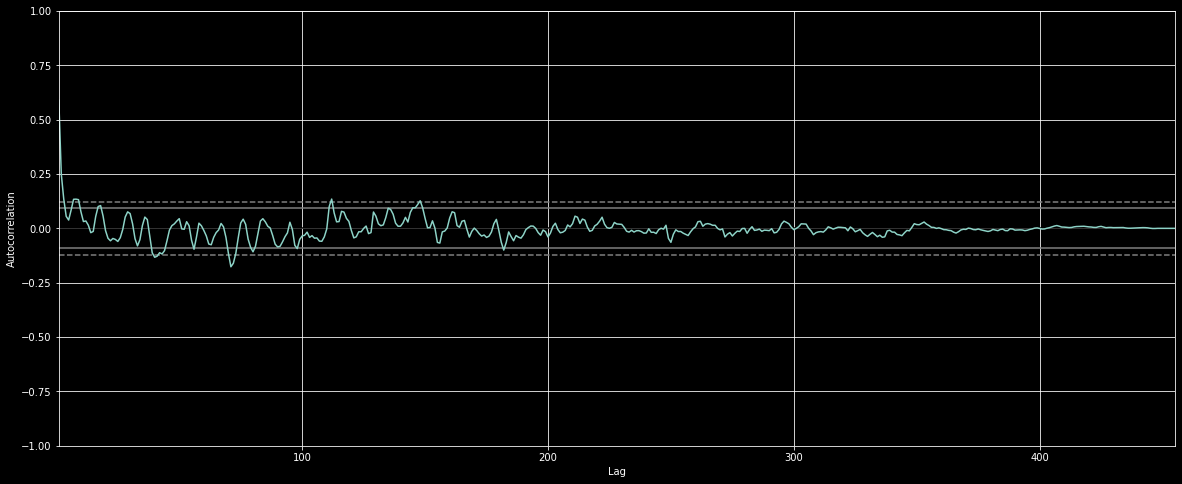

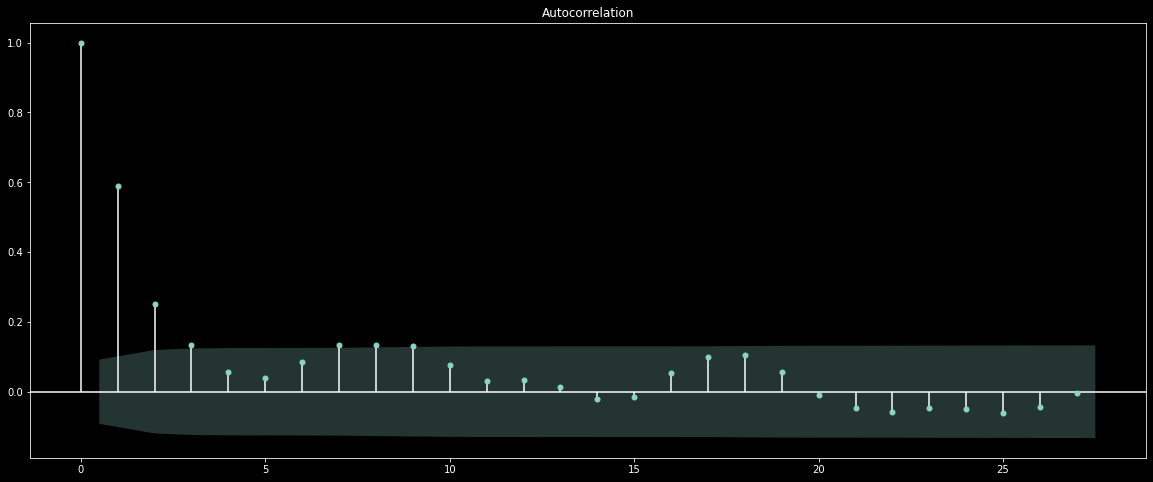

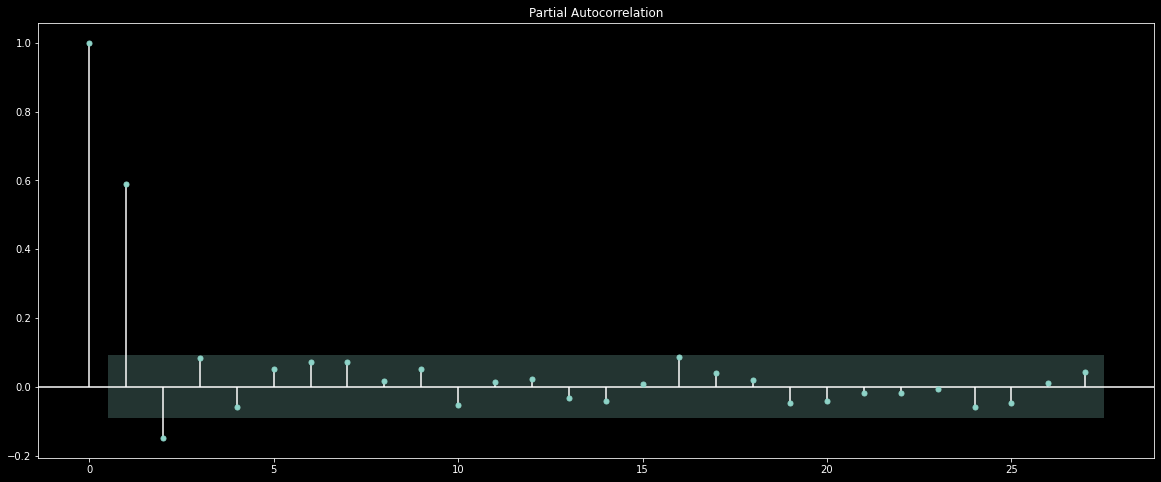

In [216]:
mean_price = ts[~ts['mean_price'].isna()]['mean_price']
autocorrelation_plot(mean_price)
plot_acf(mean_price)
plot_pacf(mean_price)

# Cross Correlation

The first plot shows the correlation with a forward lag

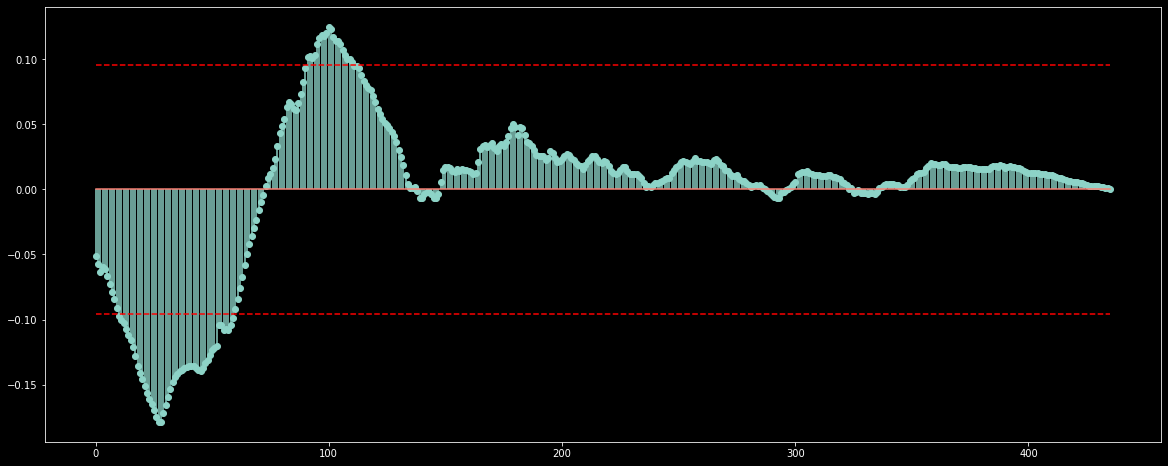

In [217]:
# correlation using just ccf and then plotting with custom function
from math import sqrt
from statsmodels.tsa.stattools import ccf

y = new_case_rate
x = mean_price[(mean_price.index >= y.index.min()) & (mean_price.index <= y.index.max())]

cross_correlation = ccf(x, y, adjusted=False)
plt.stem(cross_correlation)
ci = 2*(1/sqrt(len(x)))
plt.plot([i for i in range(len(cross_correlation))], [ci]*len(cross_correlation), color='r', ls="--")
plt.plot([i for i in range(len(cross_correlation))], [-1*ci]*len(cross_correlation), color='r', ls="--")
plt.show()

Now we show the correlation with forward and backwards lag

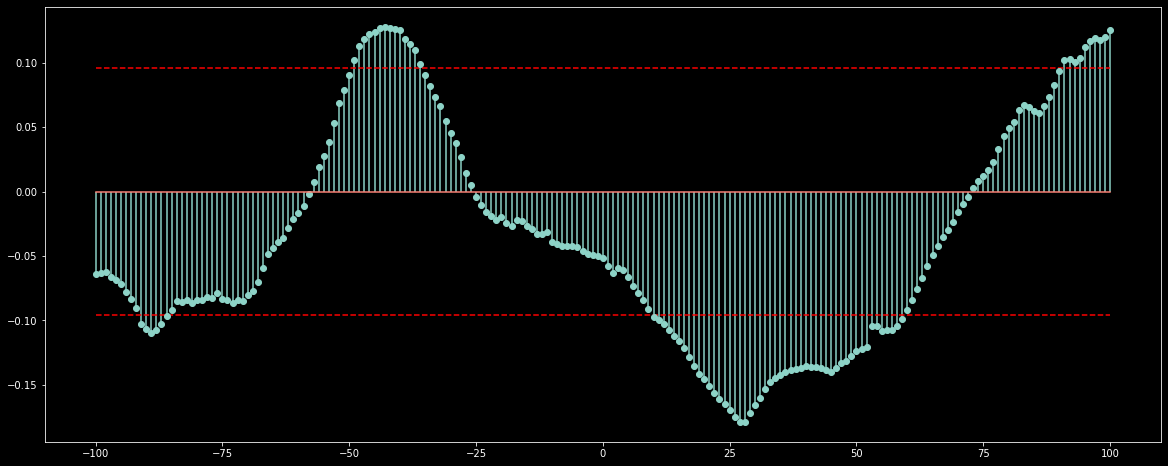

In [218]:
def ccorr_plot(x, y, values=20):
    # this function plots the cross correlation plot with positive and negative lags
    backwards = ccf(x[::-1], y[::-1], adjusted=False)[::-1][(-1*(values+1)):]
    forwards = ccf(x,y, adjusted=False)[:(values+1)]
    ccf_output = np.r_[backwards[:-1], forwards]  # we need the [:-1] because we have a duplicate for lag=0
    x_axis = list(range(-1*values, values+1))
    ci = 2*(1/sqrt(len(x)))
    plt.plot(x_axis, [ci]*len(x_axis), color='r', ls="--")
    plt.plot(x_axis, [-1*ci]*len(x_axis), color='r', ls="--")
    plt.stem(x_axis, ccf_output)
    plt.show()

ccorr_plot(x, y, 100)

# Time Series with lag

A negative value for h (lag) is a correlation between the x-variable at a time before t (the current time) and the y-variable at time t.
if h = -2 then the ccf value would give the correlation between x<sub>t-2</sub> and y<sub>t</sub>.

* if x<sub>t+h</sub> with h __negative__, is a predictor of y<sub>t</sub>, it is said that x __leads__ y.
* if x<sub>t+h</sub> with h __positive__, is a predictor of y<sub>t</sub>, it is said that x __lags__ y.

In some problems, the goal may be to identify which variable is leading and which is lagging.
In many problems we consider, though, we’ll examine the x-variable(s) to be a leading variable
of the y-variable because we will want to use values of the x-variable to predict future values of y.

I think in this case because our x is real estate and our y is covid and h is negative we can say that real estate leads covid in some weird way.
This is not what we wanted to show but it is the result we are getting.

<AxesSubplot:>

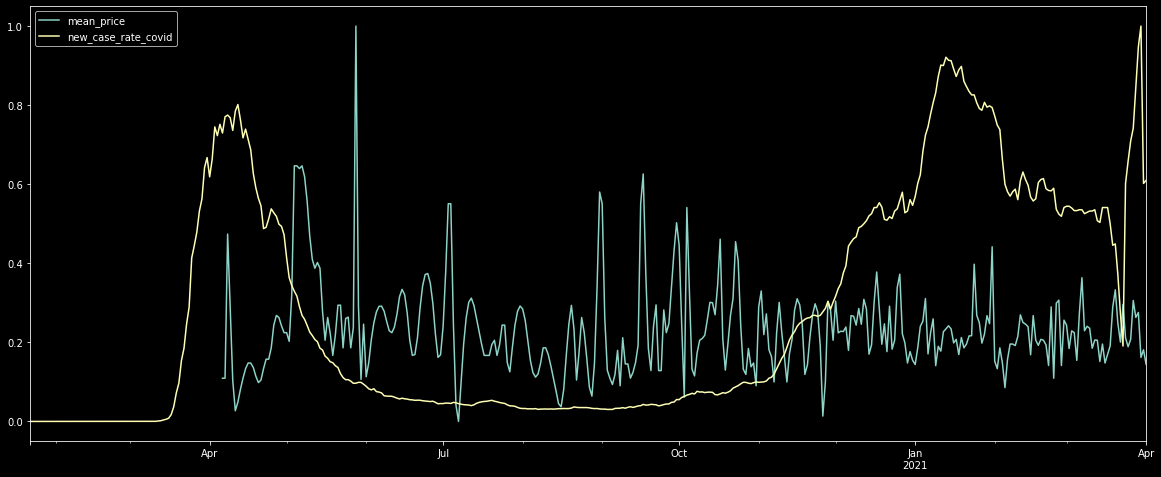

In [219]:
# x = pd.DataFrame(scaler.fit_transform(np.array(x.tolist()).reshape(-1, 1)), index=x.index)
# y  = pd.DataFrame(scaler.fit_transform(np.array(y.tolist()).reshape(-1, 1)), index=y.index)
df = pd.concat([x.shift(75), y], axis=1)
df.plot()

In [220]:
ts.corr()

mean_price  rent_count  median_price  \
mean_price                 1.000000   -0.054472      0.970768   
rent_count                -0.054472    1.000000     -0.119709   
median_price               0.970768   -0.119709      1.000000   
mean_price_per_sqft        0.099097   -0.086968      0.121610   
median_price_per_sqft      0.104655   -0.146564      0.129112   
...                             ...         ...           ...   
death_count_covid_resid   -0.011218   -0.008396     -0.010797   
death_rate_covid_resid    -0.027210    0.002282     -0.030985   
test_count_covid_resid    -0.039970    0.025323     -0.031435   
test_rate_covid_resid     -0.039504    0.025272     -0.030993   
resid                      0.791383    0.001331      0.751494   

                         mean_price_per_sqft  median_price_per_sqft  \
mean_price                          0.099097               0.104655   
rent_count                         -0.086968              -0.146564   
median_price                        0.121610               0.129112   
mean_price_per_sqft                 1.000000               0.977617   
median_price_per_sqft               0.977617               1.000000   
...                                      ...                    ...   
death_count_covid_resid            -0.014094              -0.010990   
death_rate_covid_resid             -0.043576              -0.044548   
test_count_covid_resid              0.015157               0.009651   
test_rate_covid_resid               0.014957               0.009370   
resid                               0.105345               0.105821   

                         new_case_count_covid  new_death_count_covid  ...  \
mean_price                          -0.051304               0.049803  ...   
rent_count                           0.467365              -0.029857  ...   
median_price                        -0.094761               0.074072  ...   
mean_price_per_sqft                 -0.149764               0.025766  ...   
median_price_per_sqft               -0.198303               0.030376  ...   
...                                       ...                    ...  ...   
death_count_covid_resid             -0.178077               0.062413  ...   
death_rate_covid_resid              -0.149726               0.048532  ...   
test_count_covid_resid               0.022314               0.017699  ...   
test_rate_covid_resid                0.022362               0.017587  ...   
resid                                0.005507               0.012038  ...   

                         case_count_covid_resid  case_rate_covid_resid  \
mean_price                            -0.015785              -0.016046   
rent_count                            -0.131523              -0.130047   
median_price                           0.006661               0.005429   
mean_price_per_sqft                   -0.027279              -0.025253   
median_price_per_sqft                 -0.017985              -0.016957   
...                                         ...                    ...   
death_count_covid_resid                0.266423               0.265718   
death_rate_covid_resid                 0.228310               0.228059   
test_count_covid_resid                 0.194558               0.192784   
test_rate_covid_resid                  0.194421               0.192700   
resid                                  0.006632               0.006488   

                         death_count_covid_resid  death_rate_covid_resid  \
mean_price                             -0.011218               -0.027210   
rent_count                             -0.008396                0.002282   
median_price                           -0.010797               -0.030985   
mean_price_per_sqft                    -0.014094               -0.043576   
median_price_per_sqft                  -0.010990               -0.044548   
...                                          ...                     ...   
death_count_covid_resid                 1.000

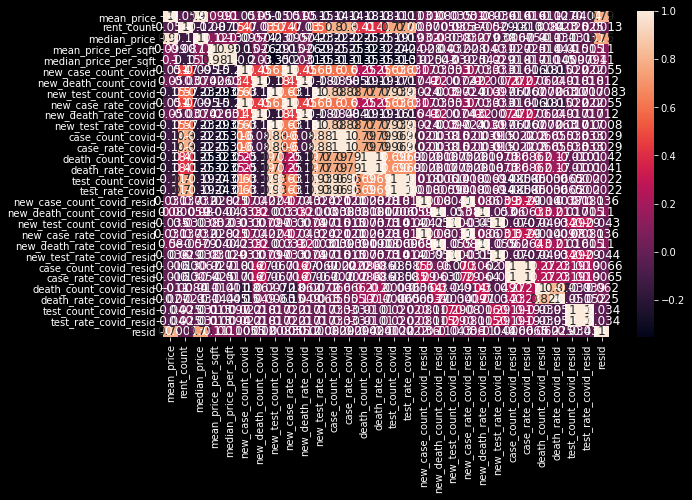

In [221]:
import seaborn as sns
corr = ts.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True,annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [222]:
# TODO: remove seasonality and apply diff


I think there is no seasonality in the real estate data but there seems to be seasons in the case-rate of covid 
but I need to do more research on this.

# Stationary Behavior
Stationary data means that the statistical properties of the particular process (mean and variance) do not vary with time.
Most TS models work on the assumption that the TS is stationary.

To test for stationarity we can use the Dickey-Fuller test. In this test the null hypothesis is that the Time series is non-stationary.
The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.
If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that
the series is stationary.

In [223]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_test(df):
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [224]:
print("COVID Results of Dicke-Fuller Test:")
dickey_fuller_test(case_rate)

COVID Results of Dicke-Fuller Test:
Test Statistic                   1.579066
p-value                          0.997793
#Lags Used                      17.000000
Number of Observations Used    418.000000
Critical Value (1%)             -3.446091
Critical Value (5%)             -2.868479
Critical Value (10%)            -2.570466
dtype: float64


It seems that we can't reject the null hypothesis in the case of COVID case-rate

In [225]:
print("Rent Results of Dicke-Fuller Test:")
dickey_fuller_test(mean_price)

Rent Results of Dicke-Fuller Test:
Test Statistic                -9.066680e+00
p-value                        4.413406e-15
#Lags Used                     2.000000e+00
Number of Observations Used    4.520000e+02
Critical Value (1%)           -3.444900e+00
Critical Value (5%)           -2.867956e+00
Critical Value (10%)          -2.570187e+00
dtype: float64


In the case of mean rent prices it seems that we can reject the null hypothesis and say that the time series is stationary

## Making COVID TS stationary
I think we can use the results from the decomposition that we got earlier and get the residual

In [226]:
test = ts['case_rate_covid_resid'][~ts['case_rate_covid_resid'].isna()]

Test Statistic                  -3.553644
p-value                          0.006712
#Lags Used                      13.000000
Number of Observations Used    416.000000
Critical Value (1%)             -3.446168
Critical Value (5%)             -2.868513
Critical Value (10%)            -2.570484
dtype: float64


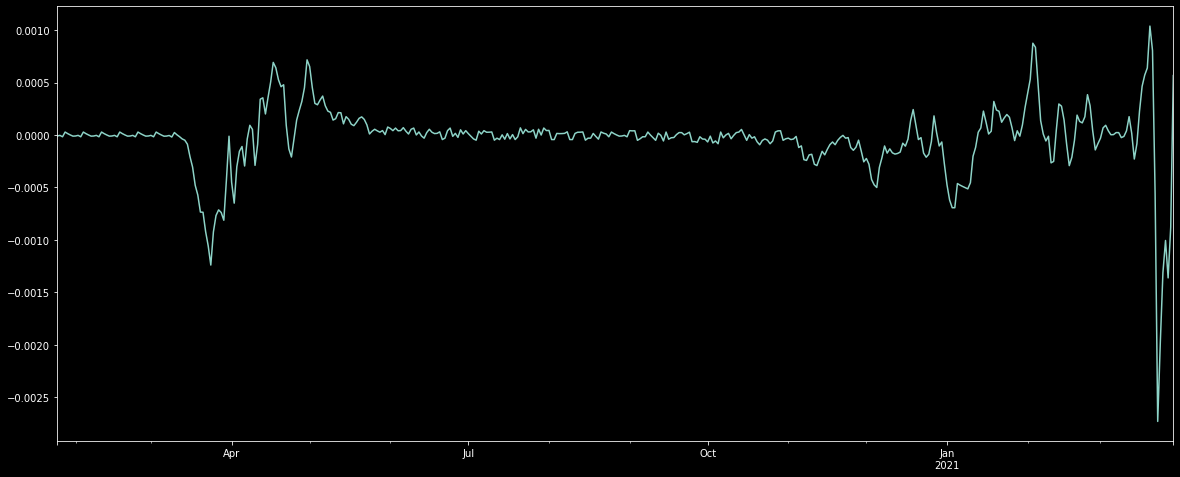

In [227]:
test.plot()
dickey_fuller_test(test)
# result_covid.plot()#%%

In [228]:
x = ts['resid'][(ts['resid'].index >= y.index.min()) & (ts['resid'].index <= y.index.max())].dropna()
x

2020-01-22   -0.131775
2020-01-23   -0.119503
2020-01-24    0.274002
2020-01-25    0.116086
2020-01-26   -0.056691
                ...   
2021-03-25    0.028113
2021-03-26   -0.015912
2021-03-27   -0.013000
2021-03-28   -0.005322
2021-03-29    0.005916
Freq: D, Name: resid, Length: 433, dtype: float64

<AxesSubplot:>

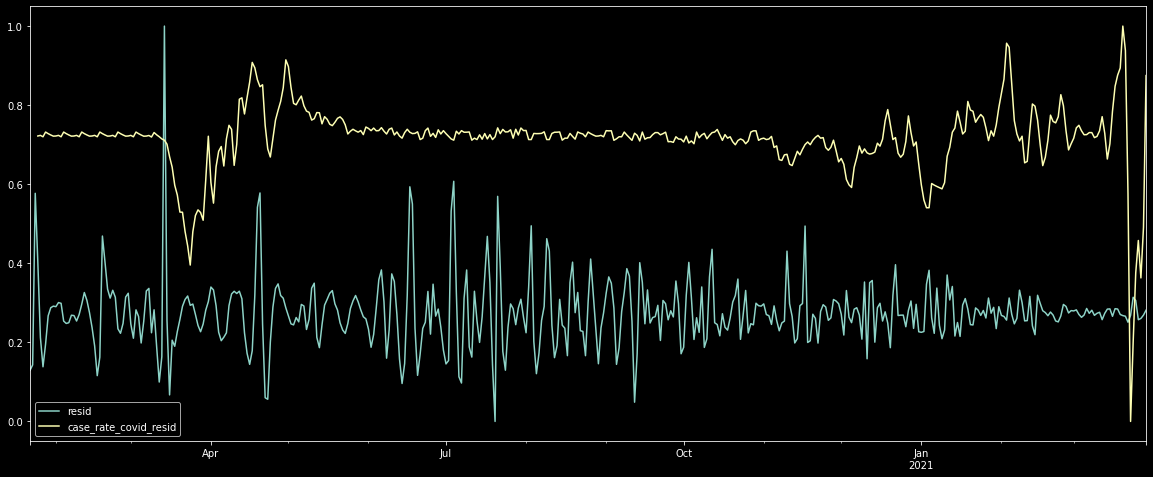

In [229]:
df = pd.concat([x, test], axis=1)
df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
df.plot()

In [230]:
df

resid  case_rate_covid_resid
2020-01-22  0.129526                    NaN
2020-01-23  0.143061                    NaN
2020-01-24  0.577047                    NaN
2020-01-25  0.402885               0.721990
2020-01-26  0.212335               0.723558
...              ...                    ...
2021-03-25  0.305863               0.376210
2021-03-26  0.257309               0.457684
2021-03-27  0.260519               0.363039
2021-03-28  0.268988               0.491296
2021-03-29  0.281382               0.874846

[433 rows x 2 columns]

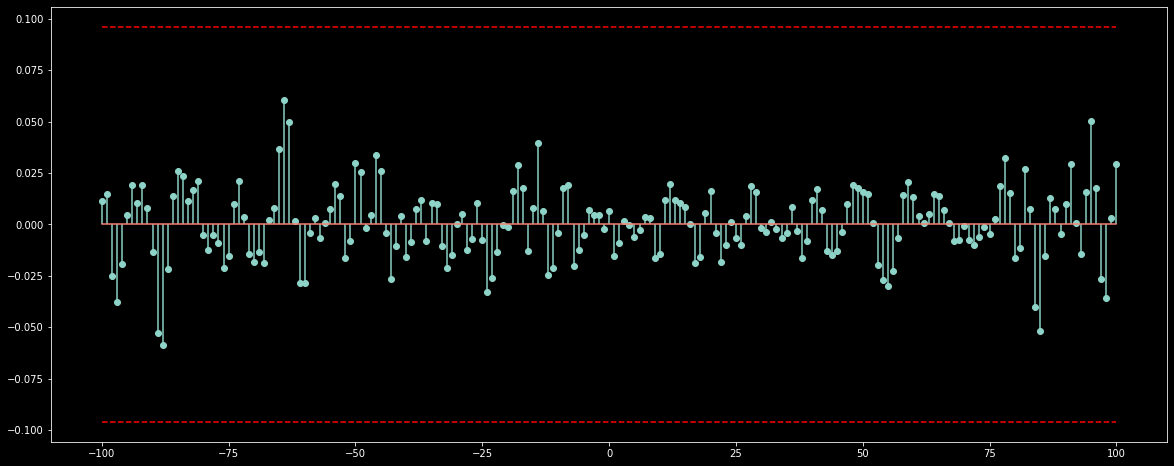

In [231]:
ccorr_plot(df['resid'].dropna(), df['case_rate_covid_resid'].dropna(), 100)

In [232]:
df.corr()

resid  case_rate_covid_resid
resid                  1.000000               0.006488
case_rate_covid_resid  0.006488               1.000000

Granger causality analysis rests on the assumption that if a variable X causes Y then changes in X will systematically occur 
before changes in Y. We will thus find that the lagged values of X will exhibit a statistically significant correlation with Y. 
Correlation however does not prove causation.

# Model Evaluation

In [233]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# model = ARIMA(df['resid'], order=(3,0, 2))

In [234]:
model = pm.auto_arima(df['resid'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=151.894, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-727.969, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-252.052, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-728.680, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-786.893, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-725.176, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1030.045, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1010.102, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-1132.625, Time=0.76 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1088.653, Time=0.42 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-1103.736, Time=0.85 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1052.280, Time=0.59 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] i

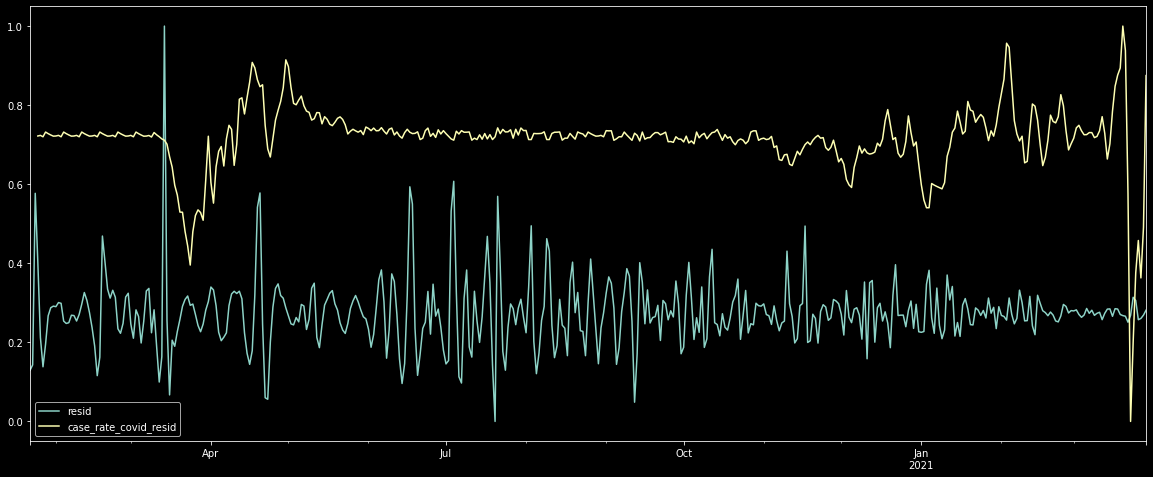

In [235]:
results_AR = model.fit(df['resid'], disp=1)
df.plot()
# plt.plot(results_AR.predict(), color='red')
# results_AR.plot_predict()
plt.show()

In [236]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

data = ts[['mean_price', 'median_price_per_sqft', 'new_case_rate_covid']]
data.fillna(data.min(), inplace=True)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [237]:
df = data
# import for Granger's Causality Test

granger_test = sm.tsa.stattools.grangercausalitytests(df[['mean_price', 'median_price_per_sqft']], maxlag=2, verbose=True)
granger_test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2745  , p=0.2595  , df_denom=453, df_num=1
ssr based chi2 test:   chi2=1.2830  , p=0.2574  , df=1
likelihood ratio test: chi2=1.2811  , p=0.2577  , df=1
parameter F test:         F=1.2745  , p=0.2595  , df_denom=453, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8562  , p=0.4255  , df_denom=450, df_num=2
ssr based chi2 test:   chi2=1.7314  , p=0.4208  , df=2
likelihood ratio test: chi2=1.7281  , p=0.4215  , df=2
parameter F test:         F=0.8562  , p=0.4255  , df_denom=450, df_num=2


{1: ({'ssr_ftest': (1.2745095717554344, 0.25951987755452266, 453.0, 1),
   'ssr_chi2test': (1.2829500324955367, 0.2573512464241573, 1),
   'lrtest': (1.2811486289574532, 0.25768557638580947, 1),
   'params_ftest': (1.274509571755247, 0.25951987755456274, 453.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.8561647637025395, 0.42547888546843127, 450.0, 2),
   'ssr_chi2test': (1.731355411042913, 0.42076630033473217, 2),
   'lrtest': (1.7280696869206622, 0.42145812946046035, 2),
   'params_ftest': (0.8561647637025626, 0.4254788854684206, 450.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [238]:
granger_test = sm.tsa.stattools.grangercausalitytests(df[['mean_price', 'new_case_rate_covid']], maxlag=2, verbose=True)
granger_test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2428  , p=0.6224  , df_denom=453, df_num=1
ssr based chi2 test:   chi2=0.2444  , p=0.6211  , df=1
likelihood ratio test: chi2=0.2443  , p=0.6211  , df=1
parameter F test:         F=0.2428  , p=0.6224  , df_denom=453, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1871  , p=0.8294  , df_denom=450, df_num=2
ssr based chi2 test:   chi2=0.3783  , p=0.8276  , df=2
likelihood ratio test: chi2=0.3782  , p=0.8277  , df=2
parameter F test:         F=0.1871  , p=0.8294  , df_denom=450, df_num=2


{1: ({'ssr_ftest': (0.24277977792146702, 0.6224443170867833, 453.0, 1),
   'ssr_chi2test': (0.24438759102028468, 0.6210549708074695, 1),
   'lrtest': (0.2443221261473809, 0.6211017278381482, 1),
   'params_ftest': (0.24277977792140948, 0.6224443170868192, 453.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.18709071013551123, 0.8294329794569959, 450.0, 2),
   'ssr_chi2test': (0.37833899160736717, 0.8276462122454991, 2),
   'lrtest': (0.378181781614785, 0.8277112719299176, 2),
   'params_ftest': (0.18709071013552098, 0.8294329794569959, 450.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [239]:
model = VAR(data)
model_fit = model.fit()

In [240]:
pred = model_fit.forecast(model_fit.y, steps=1)
print(pred)


[[0.21642385 0.46026839 0.60869521]]


/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)
